<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/pybaseball_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pybaseball tho
lol is this even legal for me

In [ ]:
!pip install pybaseball
!pip install pygam
!pip install shap

     |████████████████████████████████| 409kB 8.9MB/s 
     |████████████████████████████████| 17.7MB 238kB/s 
     |████████████████████████████████| 296kB 38.3MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 1.8MB 9.1MB/s 
     |████████████████████████████████| 327kB 8.1MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463893 sha256=409b5e8c5c7fed67698deefb0d111c346d1b78369cfd67f525e339bdb1088d1b
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [ ]:
import pybaseball
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from pygam import LinearGAM, s, f, LogisticGAM
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import lightgbm as lgb
import time
import pickle
import shap
shap.initjs()

In [ ]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls)

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective
  inputs:
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

# calc pitch level runs  
Will reference a few different pieces. First off all, this one:  
https://www.draysbay.com/2016/4/28/11521790/an-introduction-to-per-pitch-run-values

where Ian breaks up pitch level runs between pitch-specific events (balls, strikes, and the change in count) and balls in play events.

https://tht.fangraphs.com/dynamic-run-value-of-throwing-a-strike-instead-of-a-ball/

Where Dan talks more specifically about count change and run expectancy

https://www.timabe.me/blog/batting-runs/  
where tim walks you through almost exactly what i'm doing except in R and a lot more doc

In [ ]:
df = pybaseball.statcast('2019-03-20', '2019-11-01')
df['runs_scored'] = df['des'].str.count('score')
df.loc[df['events']=='home_run', 'runs_scored'] = df.loc[df['events']=='home_run', 'runs_scored'].add(1)
pitch_strikes = ['swinging_strike', 'called_strike', 'swinging_strike_blocked']
df['qualified_strikes'] = 0
df.loc[df['description'].isin(pitch_strikes), 'qualified_strikes'] = 1
df = df.merge(pd.get_dummies(df['events']), left_index=True, right_index=True)
for col in ['on_1b', 'on_2b', 'on_3b']:
  df[f'is_{col}'] = df[col].fillna(0).astype(bool).astype(int)
df = df.merge(df.loc[:, ['game_pk', 'inning', 'inning_topbot', 'bat_score']].groupby(['game_pk', 'inning', 'inning_topbot'], as_index=False).max().rename(columns={'bat_score':'runs_scored_inning_max'}))
df['runs_scored_inning_delta'] = df['runs_scored_inning_max'].sub(df['bat_score'])
df['is_lefty'] = df['p_throws'].replace(['R','L'], [0,1])

This is a large query, it may take a moment to complete
Completed sub-query from 2019-03-20 to 2019-03-25
Completed sub-query from 2019-03-26 to 2019-03-31
Completed sub-query from 2019-04-01 to 2019-04-06
Completed sub-query from 2019-04-07 to 2019-04-12
Completed sub-query from 2019-04-13 to 2019-04-18
Completed sub-query from 2019-04-19 to 2019-04-24
Completed sub-query from 2019-04-25 to 2019-04-30
Completed sub-query from 2019-05-01 to 2019-05-06
Completed sub-query from 2019-05-07 to 2019-05-12
Completed sub-query from 2019-05-13 to 2019-05-18
Completed sub-query from 2019-05-19 to 2019-05-24
Completed sub-query from 2019-05-25 to 2019-05-30
Completed sub-query from 2019-05-31 to 2019-06-05
Completed sub-query from 2019-06-06 to 2019-06-11
Completed sub-query from 2019-06-12 to 2019-06-17
Completed sub-query from 2019-06-18 to 2019-06-23
Completed sub-query from 2019-06-24 to 2019-06-29
Completed sub-query from 2019-06-30 to 2019-07-05
Completed sub-query from 2019-07-06 to 2019-

In [ ]:
re24 = df.loc[(df['balls']<4), ['outs_when_up', 'is_on_1b', 'is_on_2b', 'is_on_3b', 'runs_scored_inning_delta']].groupby(['outs_when_up', 'is_on_1b', 'is_on_2b', 'is_on_3b'], as_index=False).mean().rename(columns={'runs_scored_inning_delta':'re24'})
pd.pivot_table(re24, columns='outs_when_up', index=['is_on_1b', 'is_on_2b', 'is_on_3b'])

re24                    
outs_when_up                     0.0       1.0       2.0
is_on_1b is_on_2b is_on_3b                              
0        0        0         0.521972  0.279883  0.106505
                  1         1.384615  0.968114  0.359714
         1        0         1.132470  0.703440  0.307044
                  1         1.990229  1.374168  0.540402
1        0        0         0.929792  0.533275  0.225999
                  1         1.756390  1.207121  0.493321
         1        0         1.526628  0.946150  0.420368
                  1         2.231890  1.565534  0.697481

In [ ]:
re288 = df.loc[(df['balls']<4), ['balls', 'strikes', 'outs_when_up', 'is_on_1b', 'is_on_2b', 'is_on_3b', 'runs_scored_inning_delta']].groupby(['balls', 'strikes', 'outs_when_up', 'is_on_1b', 'is_on_2b', 'is_on_3b'], as_index=False).mean().rename(columns={'runs_scored_inning_delta':'re288'})
pd.pivot_table(re288, columns=['outs_when_up','balls', 'strikes'], index=['is_on_1b', 'is_on_2b', 'is_on_3b'])

re288            ...                    
outs_when_up                     0.0            ...       2.0          
balls                            0.0            ...       3.0          
strikes                          0.0       1.0  ...       1.0       2.0
is_on_1b is_on_2b is_on_3b                      ...                    
0        0        0         0.528076  0.483460  ...  0.164072  0.137691
                  1         1.386792  1.271605  ...  0.534545  0.429412
         1        0         1.155940  1.078947  ...  0.388889  0.288957
                  1         1.983607  1.891473  ...  0.674641  0.667961
1        0        0         0.933137  0.844457  ...  0.321218  0.265728
                  1         1.768250  1.689295  ...  0.663462  0.447059
         1        0         1.530973  1.459906  ...  0.525562  0.454625
                  1         2.267831  2.210526  ...  1.096154  0.973475

[8 rows x 36 columns]

so i was able to recreate RE24 (http://www.tangotiger.net/re24.html) and RE288 (http://tangotiger.com/index.php/site/comments/re288-run-expectancy-by-the-24-base-out-states-x-12-plate-count-states-recu)  using some simple groupbys. we'll keep going. RE288 is more accurate, and reflects pitch-level RE better (since changes in count == changes due to pitch).

In [ ]:
_re = re24.merge(re288)
df = df.merge(_re)

now we can get the value of events to confirm our run expectancy validity per PA-ending event

In [ ]:
out_events = ['field_out', 'force_out', 'sac_bunt', 'sac_fly',
              'fielders_choice_out', 'double_play', 'sac_fly_double_play',
              'strikeout_double_play', 'caught_stealing_2b', 'pickoff_1b',
              'pickoff_3b', 'pickoff_caught_stealing_2b', 'other_out',
              'pickoff_caught_stealing_home', 'pickoff_2b',
              'caught_stealing_3b','batter_interference',
              'sac_bunt_double_play', 'triple_play', 'caught_stealing_home',
              'pickoff_caught_stealing_3b']

In [ ]:
_df = df.loc[:, ['game_pk', 'inning', 'inning_topbot','at_bat_number', 'pitch_number','balls', 'strikes', 'outs_when_up', 'is_on_1b', 'is_on_2b', 'is_on_3b', 'bat_score', 're288', 'runs_scored_inning_delta']].dropna().sort_values(['game_pk', 'inning', 'inning_topbot','at_bat_number', 'pitch_number'], ascending=[1, 1, 0, 1, 1]).reset_index(drop=True).copy()
_df['game_pk_post'] = _df['game_pk'].shift(-1)
_df['re288_post'] = _df['re288'].shift(-1)
_df['inning'] = _df['inning'].astype(int)
_df['inning_post'] = _df['inning'].shift(-1)
_df['inning_topbot_post'] = _df['inning_topbot'].shift(-1)
_df['bat_score_post'] = _df['bat_score'].shift(-1)
_df.loc[(_df['game_pk']==565677) & (_df['inning']==7) & (_df['at_bat_number']==63) & (_df['pitch_number']==4), 'bat_score_post'] = 1
_df['bat_score_delta'] = _df['bat_score_post'].sub(_df['bat_score'])
_df.loc[_df['game_pk']!=_df['game_pk_post'], 'bat_score_delta'] = 0
_df.loc[_df['inning_topbot']!=_df['inning_topbot_post'], 'bat_score_delta'] = 0
_df.loc[_df['inning_post']!=_df['inning'], 're288_post'] = 0
_df['re288_delta'] = _df['re288_post'].sub(_df['re288']).add(_df['bat_score_delta'])
df_with_re = df.merge(_df)

In [ ]:
df_with_re.loc[(df['balls']<4) & (df_with_re['strikes']<3), ['events', 're288_delta']].groupby('events', as_index=False).mean().sort_values('re288_delta', ascending=False)

events  re288_delta
13                      home_run     1.358444
30                        triple     1.035294
4                         double     0.747574
8                fielders_choice     0.745233
27                        single     0.459948
6                    field_error     0.447406
14                    interf_def     0.389227
12                  hit_by_pitch     0.362655
32                          walk     0.218723
25                       sac_fly    -0.010946
23                      sac_bunt    -0.104751
16                    pickoff_1b    -0.197234
28                     strikeout    -0.285141
7                      field_out    -0.344766
15                     other_out    -0.348437
10                     force_out    -0.494539
9            fielders_choice_out    -0.661745
19    pickoff_caught_stealing_2b    -0.782643
29         strikeout_double_play    -0.843240
11     grounded_into_double_play    -0.931640
1             caught_stealing_2b    -0.947078
5                    double_play    -1.038476
3           caught_stealing_home    -1.189393
24          sac_bunt_double_play    -1.363679
18                    pickoff_3b    -1.490587
22                           run    -1.607388
26           sac_fly_double_play    -1.710119
0            batter_interference    -1.750925
17                    pickoff_2b    -2.037738
21  pickoff_caught_stealing_home    -2.148933
2             caught_stealing_3b    -2.219391
31                   triple_play    -2.590402
20    pickoff_caught_stealing_3b    -2.723826

In [ ]:
df_with_re.loc[df_with_re['events'].isin(out_events), 're288_delta'].mean()

-0.352645481588512

In [ ]:
df_with_re.loc[:, ['type', 're288_delta']].groupby('type', as_index=False).mean()

type  re288_delta
0    B     0.060939
1    S    -0.077841
2    X    -0.011378

This looks pretty good and is in line with a few different sources (https://library.fangraphs.com/principles/linear-weights/ ;  https://www.timabe.me/blog/batting-runs/). also, just based on previous experience, this looks correct. at the pitch level, a ball is not good for the pitcher (+0.06 runs per ball) and a strike is good for the pitcher (-0.08 runs per strike).  

# calc location values
this is super generalized. will dive more into this, but i think this visual example is a good sketch of what i ultimately want to create (with some strong caveats i address at the end).

In [ ]:
for col in ['plate_x', 'plate_z']:
  df_with_re[f'{col}_round'] = df_with_re[col].mul(4).round(0).div(4)

_a = df_with_re.loc[:, ['game_pk', 'inning', 'inning_topbot', 're288_delta']].groupby(['game_pk', 'inning', 'inning_topbot'], as_index=False).count().rename(columns={'re288_delta':'num_pitches'})
_b = df_with_re.loc[:, ['game_pk', 'inning', 'inning_topbot', 're288_delta']].groupby(['game_pk', 'inning', 'inning_topbot'], as_index=False).sum()
_c = df_with_re.loc[:, ['game_pk', 'inning', 'inning_topbot', 'runs_scored_inning_delta']].groupby(['game_pk', 'inning', 'inning_topbot'], as_index=False).max()
df_adj = _a.merge(_b).merge(_c)
df_adj['inning_adj'] = (df_adj['runs_scored_inning_delta'].sub(df_adj['re288_delta'])).div(df_adj['num_pitches'])
df_adj = df_adj.drop(['num_pitches', 're288_delta', 'runs_scored_inning_delta'], axis=1)
df_with_re = df_with_re.merge(df_adj)
df_with_re['pitch_level_runs'] = df_with_re['re288_delta'].add(df_with_re['inning_adj'])

plot_data = df_with_re.copy()
plot_data['plate_x'] = plot_data['plate_x'].mul(-1)
qual_locs = plot_data.loc[:, ['plate_x_round', 'plate_z_round', 'pitch_level_runs']].groupby(['plate_x_round', 'plate_z_round'], as_index=False).count()
qual_locs = qual_locs.loc[qual_locs['pitch_level_runs']>qual_locs['pitch_level_runs'].median(), ['plate_x_round', 'plate_z_round']]
loc_vals = plot_data.loc[:, ['plate_x_round', 'plate_z_round', 'pitch_level_runs']].groupby(['plate_x_round', 'plate_z_round'], as_index=False).mean()
loc_vals = loc_vals.merge(qual_locs.loc[:, ['plate_x_round', 'plate_z_round']])
df_with_re = df_with_re.merge(loc_vals.rename(columns={'pitch_level_runs':'loc_vals'}))

df_with_re.shape

(734853, 143)

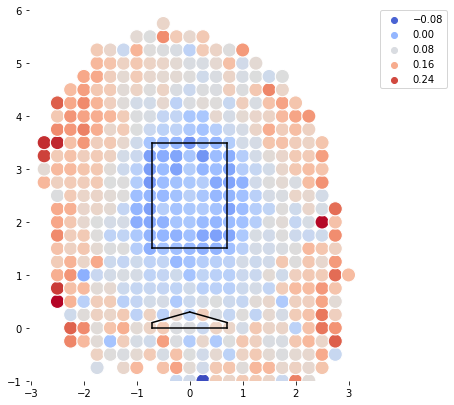

In [ ]:
fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=loc_vals, hue='pitch_level_runs', palette='coolwarm', s=200)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

so this is a location representation of value. certain places will generate better value than others. so if someone throws somewhere, we could say "that pitch would have been better if you threw it _here_ instead of _there_." that difference in location would be the lost value due to placement. let's try.

In [ ]:
random_pitch = df_with_re.loc[:, ['des', 'events', 'type', 'plate_x', 'plate_z', 'pitch_level_runs', 'plate_x_round', 'plate_z_round']].sample(1)
random_pitch

des  ... plate_z_round
306214  Albert Pujols grounds out, second baseman Mich...  ...           3.0

[1 rows x 8 columns]

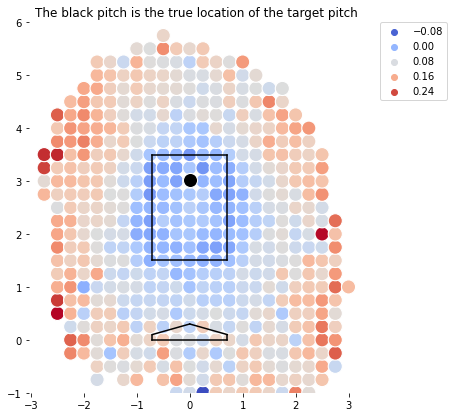

In [ ]:
fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=loc_vals, hue='pitch_level_runs', palette='coolwarm', s=200)
fig = sns.scatterplot(x='plate_x',y='plate_z',data=random_pitch, color='k', s=200)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

plt.title('The black pitch is the true location of the target pitch')

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

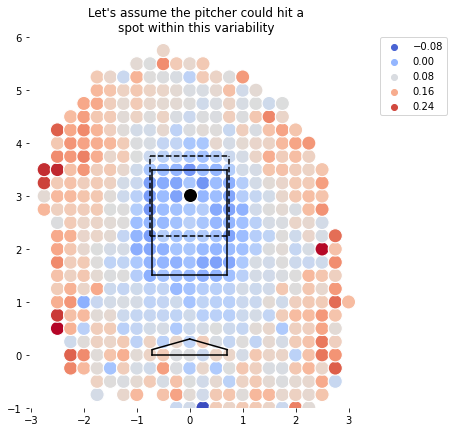

In [ ]:
top_rand_pitch = random_pitch['plate_z_round'].add(.75).values[0]
bot_rand_pitch = random_pitch['plate_z_round'].sub(.75).values[0]
left_rand_pitch = random_pitch['plate_x_round'].sub(.75).values[0]
right_rand_pitch = random_pitch['plate_x_round'].add(.75).values[0]

fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=loc_vals, hue='pitch_level_runs', palette='coolwarm', s=200)
fig = sns.scatterplot(x='plate_x',y='plate_z',data=random_pitch, color='k', s=200)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

plt.title("Let's assume the pitcher could hit a\nspot within this variability")
plt.plot([left_rand_pitch, right_rand_pitch], [bot_rand_pitch,bot_rand_pitch], 'k--')
plt.plot([left_rand_pitch, left_rand_pitch], [bot_rand_pitch,top_rand_pitch], 'k--')
plt.plot([right_rand_pitch, right_rand_pitch], [bot_rand_pitch,top_rand_pitch], 'k--')
plt.plot([left_rand_pitch, right_rand_pitch], [top_rand_pitch,top_rand_pitch], 'k--')

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()





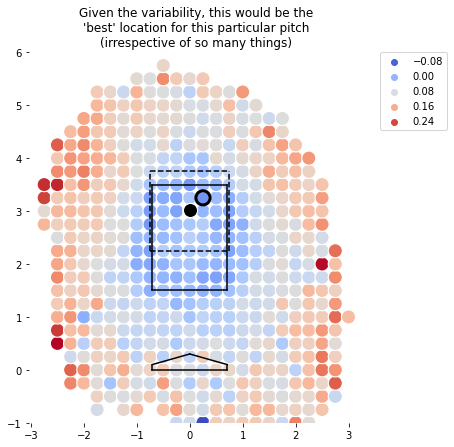

In [ ]:
best_loc = loc_vals.loc[(loc_vals['plate_x_round'].between(left_rand_pitch, right_rand_pitch)) & (loc_vals['plate_z_round'].between(bot_rand_pitch, top_rand_pitch))]
best_loc = best_loc.sort_values('pitch_level_runs').iloc[[0]]

fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=loc_vals, hue='pitch_level_runs', palette='coolwarm', s=200)
fig = sns.scatterplot(x='plate_x',y='plate_z',data=random_pitch, color='k', s=200)
fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=best_loc, s=200, linewidth=3, facecolor='none', edgecolor='k')
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

plt.title("Given the variability, this would be the\n'best' location for this particular pitch\n(irrespective of so many things)")
plt.plot([left_rand_pitch, right_rand_pitch], [bot_rand_pitch,bot_rand_pitch], 'k--')
plt.plot([left_rand_pitch, left_rand_pitch], [bot_rand_pitch,top_rand_pitch], 'k--')
plt.plot([right_rand_pitch, right_rand_pitch], [bot_rand_pitch,top_rand_pitch], 'k--')
plt.plot([left_rand_pitch, right_rand_pitch], [top_rand_pitch,top_rand_pitch], 'k--')

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()





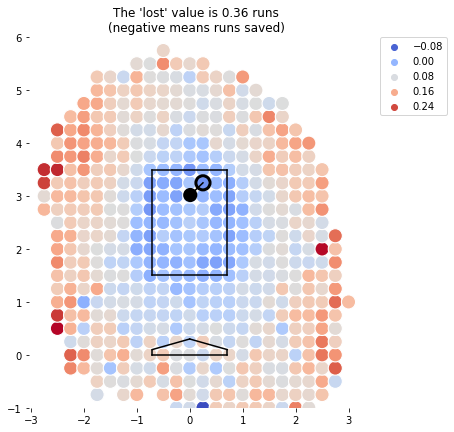

In [ ]:
lost_value = best_loc['pitch_level_runs'].values[0] - random_pitch['pitch_level_runs'].values[0]

fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=loc_vals, hue='pitch_level_runs', palette='coolwarm', s=200)
fig = sns.scatterplot(x='plate_x',y='plate_z',data=random_pitch, color='k', s=200,zorder=6, edgecolor='none')
fig = sns.scatterplot(x='plate_x_round',y='plate_z_round',data=best_loc, s=200, linewidth=3, facecolor='none', edgecolor='k',zorder=6)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

plt.title(f"The 'lost' value is {round(lost_value, 3)} runs\n(negative means runs saved)")
plt.plot([random_pitch['plate_x'].values[0], best_loc['plate_x_round'].values[0]], [random_pitch['plate_z'].values[0], best_loc['plate_z_round'].values[0]], 'k-',zorder=5)

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()


In [ ]:
df_with_re.loc[(df_with_re['player_name']=='Clayton Kershaw'), ['plate_x', 'plate_z']].shape

(2658, 2)

No handles with labels found to put in legend.


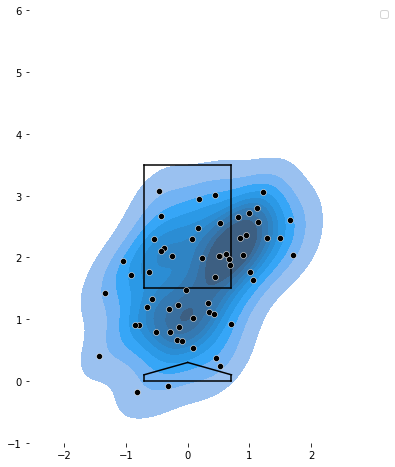

In [ ]:
df_pitch = df_with_re.loc[(df_with_re['player_name']=='Yu Darvish') & (df_with_re['pitch_type']=='KC'), ['plate_x', 'plate_z']]
df_pitch['plate_x'] = df_pitch['plate_x'].mul(-1)
fig = sns.kdeplot(x='plate_x', y='plate_z', data=df_pitch, shade=True, zorder=2)
fig = sns.scatterplot(x='plate_x', y='plate_z', data=df_pitch, zorder=3, color='k')

# df_pitch = df_with_re.loc[(df_with_re['player_name']=='Luis Castillo') & (df_with_re['pitch_type']=='CH'), ['plate_x', 'plate_z']]
# df_pitch['plate_x'] = df_pitch['plate_x'].mul(-1)
# fig = sns.kdeplot(x='plate_x', y='plate_z', data=df_pitch, shade=True, alpha=.4)

fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=False)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)

plt.show()

a few things:  

obviously, different pitch types will generate different value locations. we wouldn't expect a curveball to have similar location value as a fastball since curveballs are generally located down or below the zone and fastballs generally are high or above the zone.  

the distribution of where a pitcher can put a pitch is highly dependent on the pitcher's ability to command the pitch type. that is to say, the accuracy of a pitch is the "control" and the precision of a pitch is "command". think of a curveball again. a curveball that looks like a curveball every time has good control. a curveball that is located in the same place every time has good command. curveballs that vary in either of these aspects would be knocks on their qualitative nature. quantitatively, if the break of a pitch is inconsistent, then the pitcher exhibits less control of the pitch; likewise, if the location of a pitch is inconsistent, then the pitcher exhibits less command of a pitch. so a really bad pitch in either of these factors would most likely result in poor zone precision and the location variability of this pitch would be very large. the opposite of this -- a pitch with good control and good command -- would have a smaller variability. in some circumstances, a particular pitch may have multimodal distributions (i.e. ability to locate the pitch to different parts of the zone frequently and consistently). so assuming about a 2ft x 2ft variability for every pitch is definitely naive (and perhaps more on the "good command" side of things) but this is simply a demonstration.

even more on this topic -- i don't suspect a square shape for a pitcher's location variability. more likely it would be some sort of elongated ellipse with the angle of the ellipse in the direction of the relative break (sliders would look like a long diagonal oval whereas fastballs look like a shorter, almost-circle, and so on for each pitch type).  

the overall location and distance can be solved with some very simple math (like i did above) but perhaps it would be even easier to solve this via some sort of distance function and minimization (maximization?) weight. but perhaps that's more of a machine learning problem to tackle later on.   

another "for later" thing is location intent. it's really difficult (and most likely near impossible) to know the pitcher's intent of where they personally want to locate the pitch. if we assume they are always trying to paint the corners of the zone, then we could limit the search for optimal value to strict quadrants plus a variability component. if we limit to quadrants and assume that's the corner of the zone they wanted to go to all along, then that would really assume pitchers never have balls slip out of their hands, cross ups with the catcher never happen, pitchers with indistinct pitch types are suddenly great with command, etc. a way to make a proxy for this is to use a pitcher-pitch type distribution and see what zones they could actually locate (i.e. if a certain pitch type really locates only at the high-inside of the zone and the bottom-away of the zone), find a midpoint in the distribution, and divide the distribution of pitches. think of a slider with poor command. the ideal location is low and away from the batter but due to the break and shape of the pitch, a lot of the pitches travel on a diagonal path and up and near the batter and everywhere through the strike zone. so this pitcher may always have the intent to locate at one place, but can't command the pitch enough and ends up hanging the slider occassionally/often. so it would be very hard to say this pitcher's slider was locating high and inside on a batter because 1) that is not a typical place for a slider, 2) that assumes the pitcher could consistently hit that spot on purpose, and 3) the pitcher wanted to throw a slider in that location in the first place (which, based on the first two points here, would be extremely unlikely).  

so, as a general leap of faith here, this is really more of a demonstration of location value and not necessarily a very accurate representation of location value. some of these things would be difficult to solve with public data/public knowledge but other things could be solved given time and some creativity.

as a teaser, the complete "stuff" equation should be something like:  

$\text{stuff score} = (\text{actual location value} - \text{best location value}) + \text{actual movement value}$  

where the difference in location value is a tax on the movement of the pitch. so if you throw a really great slider, then you don't necessarily need to hit the perfect location precisely for the pitch to be effective (think sliders with great horizontal break; they may end up outside the zone a lot and therefore not in an ideal location but the movement generates a great deal of pitch value due to swing and miss. so it is possible that a bad location doesn't necessarily mean a bad pitch. rather, bad movement leads to a smaller area of precision in order for a pitch to be valuable. and a smaller area of precision given a poorly designed pitch is unlikely to equate to good stuff. in a similar fashion, a poorly designed pitch that is located well also doesn't indicate good stuff. if a pitch could be designed to have even better movement, then perhaps location becomes less important.





# pitch location value

In [ ]:
model_feats = ['is_lefty', 'release_pos_x', 'release_pos_z',
               'release_extension', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
               'release_spin_rate']
model_feats_pitch_loc = model_feats + ['pfx_x_pred', 'pfx_z_pred','release_speed_pred']

In [ ]:
# pitch_release_models = {}
# for target in ['pfx_x', 'pfx_z','release_speed']:
#   test_data = df_with_re.dropna(subset=model_feats+[target]).sample(frac=.1)
#   train_data = df_with_re.loc[~df_with_re.index.isin(test_data.index.values)].dropna(subset=model_feats+[target])

#   model = LinearRegression()
#   model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
#   pitch_release_models[f"{target}_model"] = model
#   test_data[f'{target}_pred'] = model.predict(test_data.loc[:, model_feats])

# filename = f"drive/MyDrive/baseball/models/{time.strftime('%Y%m%d%H%M%S')}_pitch_release_models.model"
# pickle.dump(pitch_release_models, open(filename, 'wb'))

# pitch_location_models = {}
# for target in ['plate_x', 'plate_z']:
#   test_data = df_with_re.dropna(subset=model_feats_pitch_loc+[target]).sample(frac=.1)
#   train_data = df_with_re.loc[~df_with_re.index.isin(test_data.index.values)].dropna(subset=model_feats_pitch_loc+[target])

#   model = LinearRegression()
#   model.fit(train_data.loc[:, model_feats_pitch_loc], train_data.loc[:, target])
#   pitch_location_models[f"{target}_model"] = model
#   test_data[f'{target}_pred'] = model.predict(test_data.loc[:, model_feats_pitch_loc])

# filename = f"drive/MyDrive/baseball/models/{time.strftime('%Y%m%d%H%M%S')}_pitch_location_models.model"
# pickle.dump(pitch_location_models, open(filename, 'wb'))

In [ ]:
# open model with this shit
pitch_release_models_fns = [f"drive/MyDrive/baseball/models/{x}" for x in os.listdir(f"drive/MyDrive/baseball/models") if 'pitch_release_models' in x]
pitch_release_models_fns.sort(reverse=True)
model_fn = pitch_release_models_fns[0]
pitch_release_models = pickle.load(open(model_fn, 'rb'))

pitch_location_models_fns = [f"drive/MyDrive/baseball/models/{x}" for x in os.listdir(f"drive/MyDrive/baseball/models") if 'pitch_location_models' in x]
pitch_location_models_fns.sort(reverse=True)
model_fn = pitch_location_models_fns[0]
pitch_location_models = pickle.load(open(model_fn, 'rb'))

In [ ]:
for target in ['pfx_x', 'pfx_z','release_speed']:
  model_data = df_with_re.loc[:, model_feats].dropna()
  model = pitch_release_models[f"{target}_model"]
  x = pd.Series(model.predict(model_data), index=model_data.index)
  df_with_re[f"{target}_pred"] = x

for target in ['plate_x', 'plate_z']:
  model_data = df_with_re.loc[:, model_feats_pitch_loc].dropna()
  model = pitch_location_models[f"{target}_model"]
  x = pd.Series(model.predict(model_data), index=model_data.index)
  df_with_re[f"{target}_pred"] = x

for col in ['plate_x_pred', 'plate_z_pred']:
  df_with_re[f'{col}_round'] = df_with_re[col].mul(4).round(0).div(4)

df_with_re = df_with_re.merge(loc_vals.rename(columns={'plate_x_round':'plate_x_pred_round', 'plate_z_round':'plate_z_pred_round','pitch_level_runs':'vacuum_val'}))

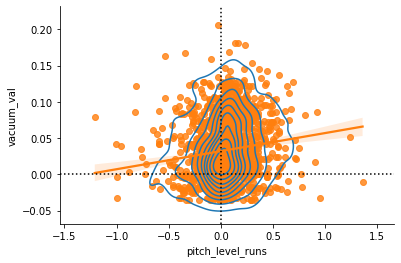

In [ ]:
sns.kdeplot(x='pitch_level_runs', y='vacuum_val',data=df_with_re.loc[df_with_re['events'].isnull()].sample(2000))
sns.regplot(x='pitch_level_runs', y='vacuum_val',data=df_with_re.loc[df_with_re['events'].isnull()].sample(2000))
plt.axhline(0, c='k', ls=':')
plt.axvline(0, c='k', ls=':')
sns.despine()
plt.show()

In [ ]:
_data = df_with_re.loc[:, ['pitcher','player_name','p_throws','pitch_type','pitch_name', 'pitch_level_runs','vacuum_val']].groupby(['pitcher','player_name','p_throws','pitch_type','pitch_name'], as_index=False).mean()
_times_thrown = df_with_re.loc[:, ['pitcher','player_name','p_throws','pitch_type','pitch_name', 'vacuum_val']].groupby(['pitcher','player_name','p_throws','pitch_type','pitch_name'], as_index=False).count().rename(columns={'vacuum_val':'times_thrown'})
_data = _data.merge(_times_thrown)

In [ ]:
_data.loc[_data['times_thrown']>=800].sort_values('pitch_level_runs').head(20)

pitcher        player_name  ... vacuum_val times_thrown
2106  608566.0     German Marquez  ...   0.024455          925
578   502706.0      Derek Holland  ...   0.028801          910
3290  670950.0    Trevor Richards  ...   0.029436          878
22    425844.0       Zack Greinke  ...   0.023353         1432
2070  608032.0     Carlos Estevez  ...   0.028678          834
411   488768.0     Andrew Cashner  ...   0.031451         1136
1839  605400.0         Aaron Nola  ...   0.032334         1179
1771  605182.0     Mike Clevinger  ...   0.031948         1054
1027  544931.0  Stephen Strasburg  ...   0.027989         1206
399   477132.0    Clayton Kershaw  ...   0.025884         1162
1413  592662.0         Robbie Ray  ...   0.030597         1303
1557  594798.0       Jacob deGrom  ...   0.032417         1533
2508  628711.0        Julio Urias  ...   0.031829          805
2356  622491.0      Luis Castillo  ...   0.037954          902
222   453562.0       Jake Arrieta  ...   0.028066         1215
982   543699.0       Tanner Roark  ...   0.029715          863
2089  608337.0      Lucas Giolito  ...   0.025969         1544
2425  623352.0         Josh Hader  ...   0.038124          962
2814  647336.0        Mike Soroka  ...   0.029542         1192
507   502042.0       Chris Archer  ...   0.033333          830

[20 rows x 8 columns]

In [ ]:
_data.loc[_data['times_thrown']>=800].sort_values('vacuum_val').head(20)

pitcher      player_name  ... vacuum_val times_thrown
1564  594835.0   Marco Gonzales  ...   0.021512         1214
14    425794.0  Adam Wainwright  ...   0.021619         1133
922   543294.0   Kyle Hendricks  ...   0.022191         1117
470   501381.0   Michael Pineda  ...   0.023145         1182
22    425844.0     Zack Greinke  ...   0.023353         1432
1054  547888.0  Masahiro Tanaka  ...   0.023714         1012
3264  669456.0     Shane Bieber  ...   0.023746         1474
1154  571760.0    Andrew Heaney  ...   0.023846          977
734   519242.0       Chris Sale  ...   0.024147          932
3114  663978.0    Chris Paddack  ...   0.024165         1390
1118  571510.0     Matthew Boyd  ...   0.024326         1506
494   501985.0       Mike Minor  ...   0.024407          824
2106  608566.0   German Marquez  ...   0.024455          925
1841  605400.0       Aaron Nola  ...   0.024513         1172
1650  596057.0    Daniel Norris  ...   0.024782         1058
1485  592866.0  Trevor Williams  ...   0.024895         1208
3160  664192.0    Joey Lucchesi  ...   0.025023         1352
2492  628317.0      Kenta Maeda  ...   0.025050          832
1879  605483.0      Blake Snell  ...   0.025090          973
1259  572971.0   Dallas Keuchel  ...   0.025098          967

[20 rows x 8 columns]

In [ ]:
_data.loc[_data['times_thrown']>=800].sort_values('vacuum_val').tail(20)

pitcher        player_name  ... vacuum_val times_thrown
507   502042.0       Chris Archer  ...   0.033333          830
2064  607644.0         John Means  ...   0.033715         1358
464   500779.0      Jose Quintana  ...   0.033800          991
1289  573186.0     Marcus Stroman  ...   0.034332          910
990   543766.0         Bryan Shaw  ...   0.034438          891
783   527048.0       Martin Perez  ...   0.034510          853
3267  669456.0       Shane Bieber  ...   0.035079          848
2355  622491.0      Luis Castillo  ...   0.035368          997
519   502154.0       Zack Britton  ...   0.036660          857
868   543037.0        Gerrit Cole  ...   0.037371          879
1102  570632.0         Jose Urena  ...   0.037423          860
1634  596001.0        Jakob Junis  ...   0.037777          854
2356  622491.0      Luis Castillo  ...   0.037954          902
1129  571578.0     Patrick Corbin  ...   0.038119         1268
2425  623352.0         Josh Hader  ...   0.038124          962
2807  645261.0    Sandy Alcantara  ...   0.038735          851
1525  593958.0  Eduardo Rodriguez  ...   0.039852          812
1416  592662.0         Robbie Ray  ...   0.040297          921
1026  544931.0  Stephen Strasburg  ...   0.042472          808
1559  594798.0       Jacob deGrom  ...   0.042586         1022

[20 rows x 8 columns]

In [ ]:
_stage = df_with_re.loc[df_with_re['player_name']=='Kevin Gausman']
_data = _stage.loc[:, ['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name','pitch_level_runs','vacuum_val']].groupby(['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name'], as_index=False).sum()
_data2 = _stage.loc[:, ['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name','pitch_level_runs','vacuum_val']].groupby(['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name'], as_index=False).mean()
_times_thrown = _stage.loc[:, ['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name', 'vacuum_val']].groupby(['pitcher','player_name','p_throws','stand','pitch_type','pitch_name'], as_index=False).count().rename(columns={'vacuum_val':'times_thrown'})
_data = _data.merge(_times_thrown).merge(_data2, on=['pitcher','player_name','p_throws', 'stand','pitch_type','pitch_name'], suffixes=('_sum', '_mean'))

In [ ]:
_data.sort_values('pitch_level_runs_sum')

pitcher    player_name  ... pitch_level_runs_mean vacuum_val_mean
4  592332.0  Kevin Gausman  ...             -0.029657        0.030716
5  592332.0  Kevin Gausman  ...             -0.145480        0.032437
2  592332.0  Kevin Gausman  ...              0.025078        0.076953
1  592332.0  Kevin Gausman  ...              0.004492        0.038569
3  592332.0  Kevin Gausman  ...              0.075827        0.025924
0  592332.0  Kevin Gausman  ...              0.104883        0.028913

[6 rows x 11 columns]

In [ ]:
_data.loc[:, ['pitch_level_runs_sum', 'vacuum_val_sum', 'times_thrown']].sum()

pitch_level_runs_sum      72.474968
vacuum_val_sum            50.100728
times_thrown            1633.000000
dtype: float64

In [ ]:
random_game = df_with_re['game_pk'].sample(1).values[0]
df_with_re.loc[df_with_re['game_pk']==random_game, ['inning','inning_topbot','pitch_level_runs']].groupby(['inning','inning_topbot'], as_index=False).sum()

inning inning_topbot  pitch_level_runs
0      1.0           Bot     -2.081668e-17
1      1.0           Top     -8.326673e-17
2      2.0           Bot     -5.551115e-17
3      2.0           Top     -5.989853e-02
4      3.0           Bot      4.934042e+00
5      3.0           Top      2.220446e-16
6      4.0           Bot     -1.665335e-16
7      4.0           Top     -2.220446e-16
8      5.0           Bot      3.000000e+00
9      5.0           Top     -7.771561e-16
10     6.0           Bot     -1.221245e-15
11     6.0           Top      2.000000e+00
12     7.0           Bot     -8.881784e-16
13     7.0           Top     -6.661338e-16
14     8.0           Bot      2.220446e-16
15     8.0           Top      2.000000e+00
16     9.0           Top      0.000000e+00

In [ ]:
df_with_re.loc[df_with_re['game_pk']==random_game, ['inning','inning_topbot','home_score', 'away_score', 'runs_scored_inning_delta']].groupby(['inning','inning_topbot'],as_index=False).max()

inning inning_topbot  home_score  away_score  runs_scored_inning_delta
0      1.0           Bot         0.0         0.0                       0.0
1      1.0           Top         0.0         0.0                       0.0
2      2.0           Bot         0.0         0.0                       0.0
3      2.0           Top         0.0         0.0                       0.0
4      3.0           Bot         5.0         0.0                       5.0
5      3.0           Top         0.0         0.0                       0.0
6      4.0           Bot         5.0         0.0                       0.0
7      4.0           Top         5.0         0.0                       0.0
8      5.0           Bot         8.0         0.0                       3.0
9      5.0           Top         5.0         0.0                       0.0
10     6.0           Bot         8.0         2.0                       0.0
11     6.0           Top         8.0         2.0                       2.0
12     7.0           Bot         8.0         2.0                       0.0
13     7.0           Top         8.0         2.0                       0.0
14     8.0           Bot         8.0         4.0                       0.0
15     8.0           Top         8.0         4.0                       2.0
16     9.0           Top         8.0         4.0                       0.0

# swinging strike model

this will probably suck

In [ ]:
df_with_re['is_swinging_strike'] = 0
df_with_re.loc[df_with_re['description'].isin(['swinging_strike', 'swinging_strike_blocked']), 'is_swinging_strike'] = 1

In [ ]:
model_feats = model_feats_pitch_loc
target = 'is_swinging_strike'

kf = KFold(3)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(df_with_re):
  train_data = df_with_re.iloc[train_idx]
  test_data = df_with_re.iloc[test_idx]
  model = LogisticRegression(max_iter=300)
  model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
  test_data[f'{target}_pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_pred[f'{target}_pred'].describe()

count    721695.000000
mean          0.110792
std           0.031307
min           0.032412
25%           0.091494
50%           0.109867
75%           0.125220
max           0.322513
Name: is_swinging_strike_pred, dtype: float64

In [ ]:
model_feats = model_feats_pitch_loc + ['plate_x_pred', 'plate_z_pred', 'vacuum_val']
target = 'is_swinging_strike'

kf = KFold(3)
df_pred = pd.DataFrame()
for train_idx, test_idx in kf.split(df_with_re):
  train_data = df_with_re.iloc[train_idx]
  test_data = df_with_re.iloc[test_idx]
  model = RandomForestClassifier()
  model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
  test_data[f'{target}_pred'] = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index)[1]
  df_pred = df_pred.append(test_data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    721695.000000
mean          0.176714
std           0.111134
min           0.000000
25%           0.090000
50%           0.160000
75%           0.250000
max           0.720000
Name: is_swinging_strike_pred, dtype: float64

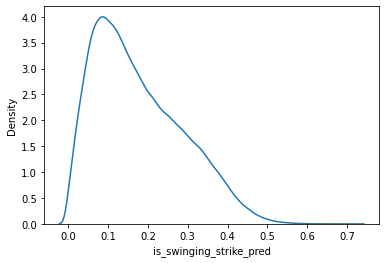

In [ ]:
sns.kdeplot(df_pred[f'{target}_pred'])
df_pred[f'{target}_pred'].describe()

In [ ]:
df_pred[f'{target}'].describe()

count    721695.000000
mean          0.111708
std           0.315007
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_swinging_strike, dtype: float64

In [ ]:
df_pred[f"{target}_pred"].round(0).describe()

count    721695.000000
mean          0.002612
std           0.051040
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_swinging_strike_pred, dtype: float64

In [ ]:
df_swstr = df_pred.loc[:, ['player_name', 'pitcher', 'pitch_type', 'pitch_name', 'is_swinging_strike', 'is_swinging_strike_pred']].groupby(['player_name', 'pitcher', 'pitch_type', 'pitch_name'],as_index=False).sum()

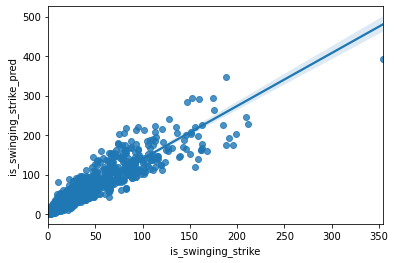

In [ ]:
sns.regplot(x='is_swinging_strike', y='is_swinging_strike_pred',data=df_swstr.sample(2000))

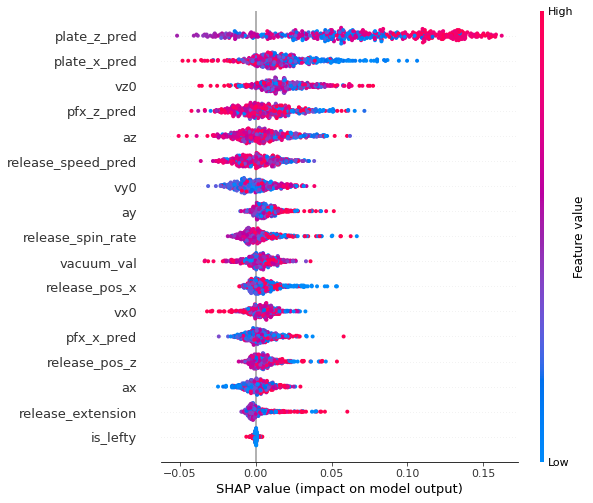

In [ ]:
shap_data = test_data.loc[:,model_feats].sample(500)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values[1], shap_data, max_display=50)

## try gbm
this better work or else sadge

In [ ]:
model_feats = model_feats_pitch_loc + ['plate_x_pred', 'plate_z_pred', 'vacuum_val']
target = 'is_swinging_strike'

df_pred = pd.DataFrame()

kf = KFold(3)
for train_idx, test_idx in kf.split(df_with_re):
  train_data = df_with_re.iloc[train_idx]
  test_data = df_with_re.iloc[test_idx]

  lgb_train_data = lgb.Dataset(train_data.loc[:, model_feats],
                          train_data.loc[:, target],
                          categorical_feature=['is_lefty'])

  lgb_test_data = lgb.Dataset(test_data.loc[:, model_feats],
                          test_data.loc[:, target],
                          categorical_feature=['is_lefty'])

  p = dict(objective='binary',
           boosting='gbdt',
           metric='binary_logloss',
           learning_rate=0.01,
           min_data_in_leaf = 1,
           min_sum_hessian_in_leaf=100)
  model = lgb.train(p,lgb_train_data, num_boost_round=6000,
                    valid_sets=lgb_test_data, early_stopping_rounds=200, verbose_eval=400)
  test_data[f'{target}_pred'] = pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0]

  df_pred = df_pred.append(test_data)

df_pred.shape

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 200 rounds.
[400]	valid_0's binary_logloss: 0.329043
[800]	valid_0's binary_logloss: 0.326492
[1200]	valid_0's binary_logloss: 0.325259
[1600]	valid_0's binary_logloss: 0.324478
[2000]	valid_0's binary_logloss: 0.323934
[2400]	valid_0's binary_logloss: 0.323584
[2800]	valid_0's binary_logloss: 0.323358
[3200]	valid_0's binary_logloss: 0.323075
[3600]	valid_0's binary_logloss: 0.322902
[4000]	valid_0's binary_logloss: 0.322807
[4400]	valid_0's binary_logloss: 0.322753
[4800]	valid_0's binary_logloss: 0.322713
[5200]	valid_0's binary_logloss: 0.322656
[5600]	valid_0's binary_logloss: 0.322624
[6000]	valid_0's binary_logloss: 0.322598
Did not meet early stopping. Best iteration is:
[5978]	valid_0's binary_logloss: 0.322595



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 200 rounds.
[400]	valid_0's binary_logloss: 0.329329
[800]	valid_0's binary_logloss: 0.326596
[1200]	valid_0's binary_logloss: 0.325383
[1600]	valid_0's binary_logloss: 0.324511
[2000]	valid_0's binary_logloss: 0.323795
[2400]	valid_0's binary_logloss: 0.323282
[2800]	valid_0's binary_logloss: 0.322929
[3200]	valid_0's binary_logloss: 0.322708
[3600]	valid_0's binary_logloss: 0.322561
[4000]	valid_0's binary_logloss: 0.322493
[4400]	valid_0's binary_logloss: 0.322445
[4800]	valid_0's binary_logloss: 0.322378
Early stopping, best iteration is:
[4901]	valid_0's binary_logloss: 0.32235
Training until validation scores don't improve for 200 rounds.
[400]	valid_0's binary_logloss: 0.320844
[800]	valid_0's binary_logloss: 0.317121
[1200]	valid_0's binary_logloss: 0.316533
[1600]	valid_0's binary_logloss: 0.316218
[2000]	valid_0's binary_logloss: 0.31546
[2400]	valid_0's binary_logloss: 0.314981
[2800]	valid_0's binary_logloss: 0.314641
[3200

(721695, 153)

In [ ]:
df_with_re['is_swinging_strike_pred'] = df_pred['is_swinging_strike_pred']

count    721695.000000
mean          0.111708
std           0.315007
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_swinging_strike, dtype: float64

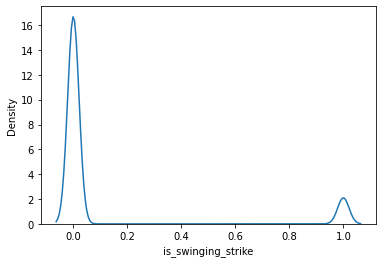

In [ ]:
sns.kdeplot(df_pred[f'{target}'])
df_pred[f'{target}'].describe()

count    721695.000000
mean          0.119634
std           0.081677
min           0.001037
25%           0.059658
50%           0.097995
75%           0.165705
max           0.614932
Name: is_swinging_strike_pred, dtype: float64

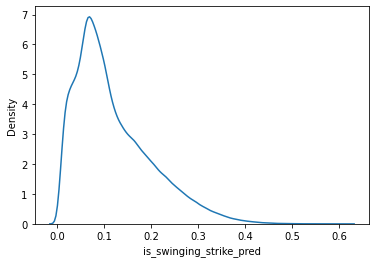

In [ ]:
sns.kdeplot(df_pred[f'{target}_pred'])
df_pred[f'{target}_pred'].describe()

count    721695.000000
mean          0.000208
std           0.014415
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_swinging_strike_pred, dtype: float64

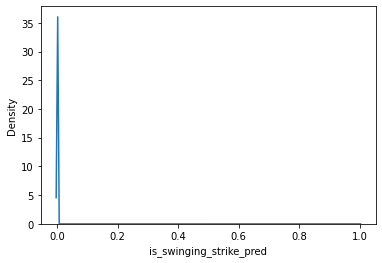

In [ ]:
sns.kdeplot(df_pred[f'{target}_pred'].round(0))
df_pred[f'{target}_pred'].round(0).describe()

In [ ]:
swstr_val = df_pred.loc[df_pred['is_swinging_strike']==1, 'pitch_level_runs'].mean()
df_pred['xswstr_val'] = df_pred['is_swinging_strike_pred'].mul(swstr_val)
df_pred['fuck'] = df_pred['xswstr_val'].add(df_pred['vacuum_val'])

count    721695.000000
mean          0.018813
std           0.039004
min          -0.136750
25%          -0.008136
50%           0.011602
75%           0.039534
max           0.268525
Name: fuck, dtype: float64

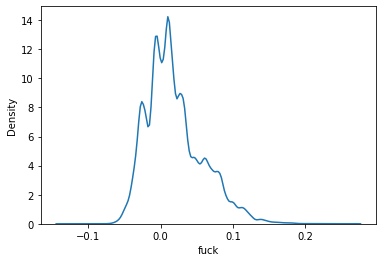

In [ ]:
sns.kdeplot(df_pred['fuck'])
df_pred['fuck'].describe()

In [ ]:
avg_pt_val

pitch_type       pitch_name  avg_pitch_type_value
0          CH         Changeup              0.018360
1          CU        Curveball              0.015927
2          EP           Eephus              0.024882
3          FC           Cutter              0.018946
4          FF  4-Seam Fastball              0.019410
5          FO         Forkball              0.011562
6          FS     Split-Finger              0.016750
7          FT  2-Seam Fastball              0.023041
8          KC    Knuckle Curve              0.016189
9          KN      Knuckleball             -0.005616
10         SI           Sinker              0.021503
11         SL           Slider              0.016351

In [ ]:
_pt_counts = df_pred.loc[:, ['player_name', 'pitcher', 'pitch_type', 'pitch_name', 'fuck']].groupby(['player_name', 'pitcher', 'pitch_type', 'pitch_name'], as_index=False).count().rename(columns={'fuck':'count'})
_pt_counts = _pt_counts.loc[_pt_counts['count']>=200]
avg_pt_val = df_pred.loc[:, ['pitch_type', 'pitch_name', 'fuck']].groupby(['pitch_type', 'pitch_name'], as_index=False).mean().rename(columns={'fuck':'avg_pitch_type_value'})
df_fuck = _pt_counts.merge(df_pred.loc[:, ['player_name', 'pitcher', 'pitch_type', 'pitch_name', 'pitch_level_runs', 'vacuum_val', 'xswstr_val', 'fuck']].groupby(['player_name', 'pitcher', 'pitch_type', 'pitch_name'], as_index=False).mean()).merge(avg_pt_val)
df_fuck['fuck_adj'] = df_fuck['fuck'].sub(df_fuck['avg_pitch_type_value'])
df_fuck = df_fuck.sort_values('fuck_adj').reset_index(drop=True)
df_fuck['ranking'] = range(1, df_fuck.shape[0]+1)

In [ ]:
df_fuck.tail(40)

player_name   pitcher  ...  fuck_adj ranking
1141       Dylan Floro  571670.0  ...  0.008842    1142
1142       A.J. Minter  621345.0  ...  0.008873    1143
1143        Edwin Diaz  621242.0  ...  0.008881    1144
1144      Jake Arrieta  453562.0  ...  0.008927    1145
1145     Merrill Kelly  518876.0  ...  0.008928    1146
1146      Gabriel Ynoa  593679.0  ...  0.009029    1147
1147       Wes Parsons  641149.0  ...  0.009047    1148
1148         Tim Mayza  641835.0  ...  0.009194    1149
1149   Fernando Rodney  407845.0  ...  0.009204    1150
1150  Taylor Guerrieri  605260.0  ...  0.009302    1151
1151    Patrick Corbin  571578.0  ...  0.009377    1152
1152       Josh Taylor  657031.0  ...  0.009403    1153
1153      Tanner Scott  656945.0  ...  0.009483    1154
1154   Brandon Workman  519443.0  ...  0.009491    1155
1155     Cal Quantrill  615698.0  ...  0.009628    1156
1156      Kevin Ginkel  656464.0  ...  0.009739    1157
1157     Michael Wacha  608379.0  ...  0.009830    1158
1158  Michael Lorenzen  547179.0  ...  0.010314    1159
1159    Framber Valdez  664285.0  ...  0.010326    1160
1160     Junior Guerra  448855.0  ...  0.010396    1161
1161       Pablo Lopez  641154.0  ...  0.010583    1162
1162    Jeurys Familia  544727.0  ...  0.010708    1163
1163         J.A. Happ  457918.0  ...  0.010902    1164
1164       Clay Holmes  605280.0  ...  0.010935    1165
1165     Hector Rondon  444468.0  ...  0.011131    1166
1166      Edgar Garcia  658305.0  ...  0.011846    1167
1167        Sonny Gray  543243.0  ...  0.011987    1168
1168   Robert Gsellman  607229.0  ...  0.012380    1169
1169     Marcus Walden  519393.0  ...  0.012466    1170
1170      Jacob deGrom  594798.0  ...  0.012600    1171
1171      Wander Suero  593833.0  ...  0.012637    1172
1172     Liam Hendriks  521230.0  ...  0.012711    1173
1173     Elvis Luciano  672773.0  ...  0.012883    1174
1174  Trevor Rosenthal  572096.0  ...  0.012943    1175
1175       Steven Matz  571927.0  ...  0.013224    1176
1176       Tyler Beede  595881.0  ...  0.013742    1177
1177  Spencer Turnbull  605513.0  ...  0.014469    1178
1178       Jay Jackson  543351.0  ...  0.015103    1179
1179     Miguel Castro  612434.0  ...  0.015974    1180
1180        Lance Lynn  458681.0  ...  0.017597    1181

[40 rows x 12 columns]

In [ ]:
df_fuck.loc[df_fuck['player_name']=='Hyun Jin Ryu']

player_name   pitcher pitch_type  ... avg_pitch_type_value  fuck_adj  ranking
41   Hyun Jin Ryu  547943.0         FT  ...             0.023041 -0.007984       42
203  Hyun Jin Ryu  547943.0         CH  ...             0.018360 -0.004298      204
437  Hyun Jin Ryu  547943.0         FC  ...             0.018946 -0.001867      438
576  Hyun Jin Ryu  547943.0         FF  ...             0.019410 -0.000502      577
786  Hyun Jin Ryu  547943.0         CU  ...             0.015927  0.001481      787

[5 rows x 12 columns]

In [ ]:
avg_fb_break = df_with_re.loc[df_with_re['pitch_type'].isin(['FF', 'FT', 'SI']), ['player_name', 'pfx_x', 'pfx_z']].groupby(['player_name'], as_index=False).mean()
df_with_re = df_with_re.merge(avg_fb_break, on=['player_name'], suffixes=('', '_fb'))
for col in ['pfx_x', 'pfx_z']:
  df_with_re[f"{col}_rel"] = df_with_re[col].sub(df_with_re[f'{col}_fb'])

df_with_re['bat_side_right'] = 0
df_with_re.loc[df_with_re['stand']=='R', 'bat_side_right'] = 1

df_with_re['throws_right'] = 0
df_with_re.loc[df_with_re['p_throws']=='R', 'throws_right'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


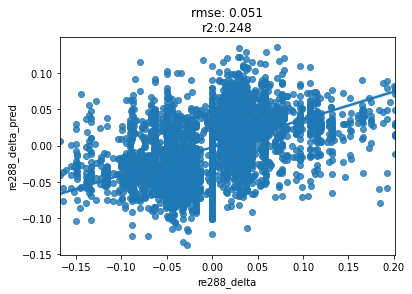

In [ ]:
model_feats = ['bat_side_right', 'plate_x', 'plate_z']
target = 're288_delta'
model_data = df_with_re.loc[df_with_re['des'].isna(), model_feats+[target]].dropna()
model_data = model_data.loc[model_data[target].between(model_data[target].quantile(0.01), model_data[target].quantile(0.99))]

kf = KFold(3, shuffle=True)
df_pred = pd.Series()

for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train.loc[:, model_feats], train.loc[:, target])
  df_pred = df_pred.append(pd.Series(model.predict(test.loc[:, model_feats]), index=test.index))
model_data[f'{target}_pred'] = df_pred

rmse = mean_squared_error(model_data[target], model_data[f"{target}_pred"])**0.5
r2 = pearsonr(model_data[target], model_data[f"{target}_pred"])[0]**2

sns.regplot(target,f"{target}_pred",data=model_data.sample(5000))
plt.title(f"rmse: {round(rmse, 3)}\nr2:{round(r2, 3)}")
plt.show()

df_with_re[f'{target}_loc_rf_pred'] = pd.Series(model.predict(df_with_re.loc[:, model_feats].dropna()), index=df_with_re.loc[:, model_feats].dropna().index)

# variability in location

i don't except a pitcher to throw at a specific spot every time. let's get the variability in location for a pitch

In [ ]:
model_feats = model_feats_pitch_loc
target = 'pitch_type_code'
model_data = df_with_re.loc[~df_with_re['pitch_type'].isin(['EP', 'FO', 'KN'])]
model_data['pitch_type_code'] = model_data['pitch_type'].astype('category').cat.codes
pt_lkup = model_data.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates()

test_data = model_data.loc[model_data['pitch_type_code']!=-1].dropna(subset=model_feats+[target]).sample(frac=.1)
train_data = model_data.loc[(~model_data.index.isin(test_data.index.values)) & (model_data['pitch_type_code']!=-1)].dropna(subset=model_feats+[target])

model = LogisticRegression()
model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
_pred = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), columns=model_data['pitch_type'].astype('category').cat.categories.values, index=test_data.index)

_pred['pitch_type_pred'] = _pred.idxmax(axis=1)
test_data = test_data.merge(_pred, left_index=True, right_index=True)
test_data = test_data.merge(pt_lkup.rename(columns={'pitch_type':'pitch_type_pred', 'pitch_type_code':'pitch_type_code_pred'}))

# filename = f"drive/MyDrive/baseball/models/{time.strftime('%Y%m%d%H%M%S')}_pitch_release_models.model"
# pickle.dump(pitch_release_models, open(filename, 'wb'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
accuracy_score(test_data[target], test_data[f"{target}_pred"])

0.6427977493832978

In [ ]:
log_loss(test_data[target], test_data.loc[:, ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'SI', 'SL']])

1.0721550734245682

In [ ]:
model = RandomForestClassifier()
model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
_pred = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), columns=model_data['pitch_type'].astype('category').cat.categories.values, index=test_data.index)

_pred['pitch_type_rf_pred'] = _pred.idxmax(axis=1)
test_data = test_data.merge(_pred, left_index=True, right_index=True, suffixes=('_linear',''))
test_data = test_data.merge(pt_lkup.rename(columns={'pitch_type':'pitch_type_rf_pred', 'pitch_type_code':'pitch_type_code_rf_pred'}))


In [ ]:
print(accuracy_score(test_data[target], test_data[f"{target}_rf_pred"]))
print(log_loss(test_data[target], test_data.loc[:, ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'SI', 'SL']]))

0.8969899387455307
0.3292012715886559


In [ ]:
test_data['is_correct'] = test_data['pitch_type_code']==test_data['pitch_type_code_rf_pred']

In [ ]:
test_data['is_correct'].mean()

0.8969899387455307

In [ ]:
test_data.loc[:, ['pitch_type', 'is_correct']].groupby('pitch_type', as_index=False).mean()

pitch_type  is_correct
0         CH    0.952375
1         CU    0.897592
2         FC    0.744034
3         FF    0.971996
4         FS    0.663138
5         FT    0.770721
6         KC    0.708732
7         SI    0.748119
8         SL    0.931212

In [ ]:
model_feats = model_feats_pitch_loc
target = 'pitch_type_code'
model_data = df_with_re.loc[~df_with_re['pitch_type'].isin(['EP', 'FO', 'KN'])]
model_data['pitch_type_code'] = model_data['pitch_type'].astype('category').cat.codes
model_data = model_data.loc[model_data['pitch_type_code']!=-1].dropna(subset=model_feats+[target])
pt_lkup = model_data.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates()

df_pred = pd.DataFrame()
kf = KFold(3, shuffle=True)
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  model = RandomForestClassifier()
  model.fit(train_data.loc[:, model_feats], train_data.loc[:, target])
  _pred = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), columns=model_data['pitch_type'].astype('category').cat.categories.values, index=test_data.index)

  _pred['pitch_type_rf_pred'] = _pred.idxmax(axis=1)
  test_data = test_data.merge(_pred, left_index=True, right_index=True, suffixes=('_linear',''))
  test_data = test_data.merge(pt_lkup.rename(columns={'pitch_type':'pitch_type_rf_pred', 'pitch_type_code':'pitch_type_code_rf_pred'}))
  df_pred = df_pred.append(test_data)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_with_re = df_with_re.merge(df_pred.loc[:, ['game_pk', 'pitcher', 'batter', 'inning', 'inning_topbot', 'outs_when_up','balls', 'strikes', 'pitch_number', 'pitch_type_rf_pred']], how='left')

In [ ]:
df_with_re.loc[df_with_re['pitch_type_rf_pred']=='FF', ['plate_x', 'plate_z']].describe()

plate_x        plate_z
count  275968.000000  275968.000000
mean        0.006998       2.696579
std         0.778581       0.841566
min        -2.850000      -0.960000
25%        -0.530000       2.130000
50%         0.010000       2.680000
75%         0.540000       3.250000
max         3.060000       5.670000

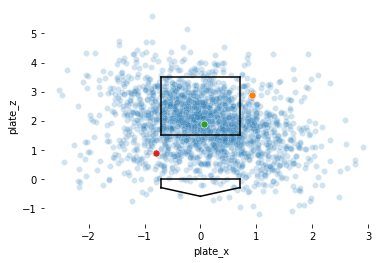

In [ ]:
df_plt = df_with_re.loc[df_with_re['pitch_type_rf_pred']=='CU', ['plate_x', 'plate_z']].sample(2000)
sns.scatterplot(x='plate_x', y='plate_z', data=df_plt, alpha=.2)
sns.scatterplot(x=[df_plt['plate_x'].mean() + df_plt['plate_x'].std()], y=[df_plt['plate_z'].mean() + df_plt['plate_z'].std()], s=50)
sns.scatterplot(x=[df_plt['plate_x'].mean()], y=[df_plt['plate_z'].mean()], s=50)
sns.scatterplot(x=[df_plt['plate_x'].mean() - df_plt['plate_x'].std()], y=[df_plt['plate_z'].mean() - df_plt['plate_z'].std()], s=50)
draw_sz()
draw_home_plate()
sns.despine(left=True, bottom=True)
plt.show()

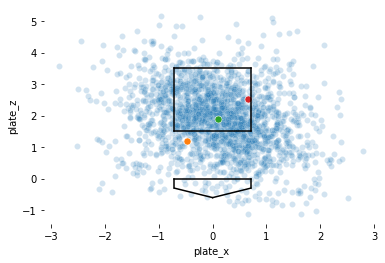

In [ ]:
df_plt = df_with_re.loc[df_with_re['pitch_type_rf_pred']=='CU', ['plate_x', 'plate_z']].sample(2000)
sns.scatterplot(x='plate_x', y='plate_z', data=df_plt, alpha=.2)
sns.scatterplot(x=[df_plt['plate_x'].quantile(.25)], y=[df_plt['plate_z'].quantile(.25)], s=50)
sns.scatterplot(x=[df_plt['plate_x'].quantile(.5)], y=[df_plt['plate_z'].quantile(.5)], s=50)
sns.scatterplot(x=[df_plt['plate_x'].quantile(.75)], y=[df_plt['plate_z'].quantile(.75)], s=50)
draw_sz()
draw_home_plate()
sns.despine(left=True, bottom=True)
plt.show()

the quantile distribution of the range of a pitch type seems more conservative than the SD -- however, it wouldn't be statistically sound to assume SD and mean would fit all pitch types since that would imply there is some sort of normal distribution of pitch locations for each pitch type. I just don't want to cross that path, so let's use quantiles instead since we don't have to assume normality.


In [ ]:
_df_with_re = df_with_re.loc[:, ['is_lefty','pitch_type','plate_x', 'plate_z']].copy()
_df_with_re.loc[_df_with_re['is_lefty']==1, 'plate_x'] = _df_with_re.loc[_df_with_re['is_lefty']==1, 'plate_x'].mul(-1)
q25 = _df_with_re.loc[:, ['pitch_type', 'plate_x', 'plate_z']].groupby('pitch_type', as_index=False).quantile(.25)
q75 = _df_with_re.loc[:, ['pitch_type', 'plate_x', 'plate_z']].groupby('pitch_type', as_index=False).quantile(.75)
pitch_type_quantiles = q25.merge(q75, on='pitch_type', suffixes=('_25', '_75'))
pitch_type_quantiles['d'] = np.sqrt((pitch_type_quantiles['plate_x_75']-pitch_type_quantiles['plate_x_25'])**2 + (pitch_type_quantiles['plate_z_75']-pitch_type_quantiles['plate_z_25'])**2)
pitch_type_quantiles['r'] = pitch_type_quantiles['d'].div(2)
df_with_re = df_with_re.merge(pitch_type_quantiles.loc[:, ['pitch_type', 'r']].rename(columns={'pitch_type':'pitch_type_rf_pred'}))
swstr_val = df_with_re.loc[df_with_re['is_swinging_strike']==1, 'pitch_level_runs'].mean()
df_with_re['swstr_val'] = df_with_re['is_swinging_strike_pred'].mul(swstr_val)

In [ ]:
def isInside(x, y, circle_x, circle_y, rad):
  """
  stolen from: https://www.geeksforgeeks.org/find-if-a-point-lies-inside-or-on-circle/

  x: target point on x-axis
  y: target point on y-axis
  circle_x: center of the circle on the x-axis
  circle_y: center of the circle on the y-axis
  rad: radius of circle

  """

  if (((x - circle_x)**2) + ((y - circle_y)**2) <= rad**2):
    return True
  else:
    return False

In [ ]:
df_with_re.columns.values

array(['index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter',
       'pitcher', 'events', 'description', 'spin_dir',
       'spin_rate_deprecated', 'break_angle_deprecated',
       'break_length_deprecated', 'zone', 'des', 'game_type', 'stand',
       'p_throws', 'home_team', 'away_team', 'type', 'hit_location',
       'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
       'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated',
       'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release

In [ ]:
df_pred = pd.DataFrame()
for idx, row in tqdm(df_with_re.iterrows(), leave=False,total=df_with_re.shape[0]):
  _df_pred = pd.DataFrame(index=[idx])
  x0 = row['plate_x_pred']
  y0 = row['plate_z_pred']
  r = row['r']
  swstr_val = row['swstr_val']
  vacuum_val = row['vacuum_val']
  ideal_loc_val = loc_vals.loc[loc_vals['plate_x_round'].sub(x0).pow(2).add(loc_vals['plate_z_round'].sub(y0).pow(2)) <= r**2, 'pitch_level_runs'].min()

  _df_pred['actual_stuff_value'] = vacuum_val + swstr_val
  _df_pred['ideal_stuff_value'] = ideal_loc_val + swstr_val
  df_pred = df_pred.append(_df_pred)

df_pred['lost_stuff'] = df_pred['actual_stuff_value'].sub(df_pred['ideal_stuff_value'])

In [ ]:
df_with_re.to_csv(f'drive/MyDrive/baseball/data/df_with_re.csv')
df_pred.to_csv(f'drive/MyDrive/baseball/data/stuff_scores.csv')

df_with_re['actual_stuff_value'] = df_pred['actual_stuff_value']
df_with_re['ideal_stuff_value'] = df_pred['ideal_stuff_value']
df_with_re['lost_stuff'] = df_pred['lost_stuff']
df_with_re.to_csv(f'drive/MyDrive/baseball/data/df_with_re.csv')

In [ ]:
actual = (-0.033109) + (-0.032357)
ideal = (-0.035) + (-0.032357)
lost_value = actual - ideal
actual, ideal, lost_value

(-0.065466, -0.067357, 0.0018910000000000038)

In [ ]:
df_with_re = pd.read_csv(f'drive/MyDrive/baseball/data/df_with_re.csv')
df_with_re.shape

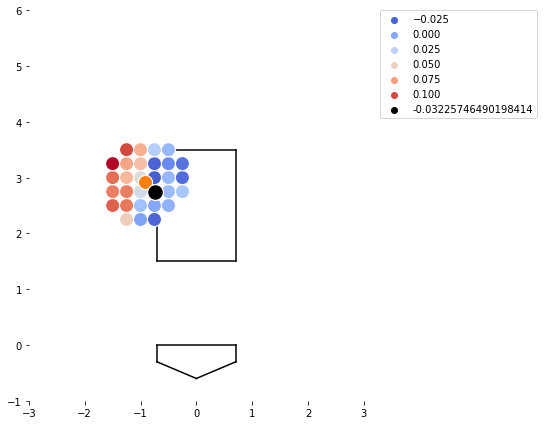

In [ ]:
_data = df_with_re.sample(1)
x0 = _data['plate_x_pred'].values[0]
y0 = _data['plate_z_pred'].values[0]
r = _data['r'].values[0]

df_plt = loc_vals.loc[loc_vals['plate_x_round'].sub(x0).pow(2).add(loc_vals['plate_z_round'].sub(y0).pow(2)) <= r**2]

fig = sns.scatterplot(x='plate_x_round', y='plate_z_round', data=df_plt, hue='pitch_level_runs', s=200, palette='coolwarm', zorder=4)
sns.scatterplot(x=[x0], y=[y0], s=200, zorder=4)
sns.scatterplot(x='plate_x_round', y='plate_z_round', data=df_plt.loc[df_plt['pitch_level_runs']==df_plt['pitch_level_runs'].min()], hue='pitch_level_runs', s=250, palette='Greys_r', zorder=5)

fig.set_xlim(-3, 3)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate()

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
rank_by = 'vacuum_val'
threshold_n = 200
threshold = (df_with_re
 .loc[:, ['pitcher','player_name', 'pitch_name', 'pitch_type', 're288_delta']]
 .groupby(['pitcher','player_name', 'pitch_name', 'pitch_type'],
          as_index=False)
 .count().rename(columns={'re288_delta':'times_thrown'}))

threshold = threshold.loc[threshold['times_thrown']>threshold_n]
pitch_ranks = (threshold
 .merge(df_with_re
        .loc[:, ['pitcher','player_name', 'pitch_name', 'pitch_type',
                 're288_delta', 'pitch_level_runs', 'vacuum_val', 'swstr_val',
                 'actual_stuff_value', 'ideal_stuff_value', 'lost_stuff']]
        .groupby(['pitcher','player_name', 'pitch_name', 'pitch_type'],
                 as_index=False)
        .mean())
 .sort_values(rank_by)).reset_index(drop=True)
pitch_ranks['rank'] = range(1,pitch_ranks.shape[0]+1)
model = LinearRegression()
model.fit(pitch_ranks.loc[:, ['vacuum_val']], pitch_ranks.loc[:, 'swstr_val'])
pitch_ranks['_split'] = pd.Series(model.predict(pitch_ranks[['vacuum_val']]), index=pitch_ranks.index) > pitch_ranks['swstr_val']

model = LinearRegression()
model.fit(pitch_ranks.loc[pitch_ranks['_split']==1, ['vacuum_val']], pitch_ranks.loc[pitch_ranks['_split']==1, 'swstr_val'])
pitch_ranks['tier1'] = pd.Series(model.predict(pitch_ranks[['vacuum_val']]), index=pitch_ranks.index) > pitch_ranks['swstr_val']

model = LinearRegression()
model.fit(pitch_ranks.loc[pitch_ranks['_split']==0, ['vacuum_val']], pitch_ranks.loc[pitch_ranks['_split']==0, 'swstr_val'])
pitch_ranks['tier3'] = pd.Series(model.predict(pitch_ranks[['vacuum_val']]), index=pitch_ranks.index) < pitch_ranks['swstr_val']

pitch_ranks['tier'] = 0
pitch_ranks.loc[(pitch_ranks['tier1']==pitch_ranks['tier3']), 'tier'] = 2
pitch_ranks.loc[(pitch_ranks['tier1']==True), 'tier'] = 1
pitch_ranks.loc[(pitch_ranks['tier3']==True), 'tier'] = 3
pitch_ranks = pitch_ranks.drop(['tier1', 'tier3'], axis=1)

In [ ]:
pitch_ranks.head()

pitcher     player_name pitch_name  ... rank  _split  tier
0  425844.0    Zack Greinke  Curveball  ...    1    True     1
1  502190.0      Mike Leake     Cutter  ...    2    True     2
2  542947.0  Richard Bleier     Sinker  ...    3   False     2
3  607560.0     Ryne Harper  Curveball  ...    4    True     1
4  542953.0   Buddy Boshers  Curveball  ...    5    True     1

[5 rows x 15 columns]

count    1179.000000
mean        0.030067
std         0.041370
min        -0.211753
25%         0.008460
50%         0.030027
75%         0.052645
max         0.215005
Name: pitch_level_runs, dtype: float64

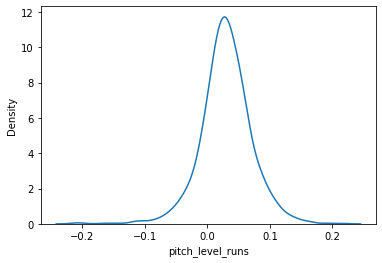

In [ ]:
sns.kdeplot(pitch_ranks['pitch_level_runs'])
pitch_ranks['pitch_level_runs'].describe()

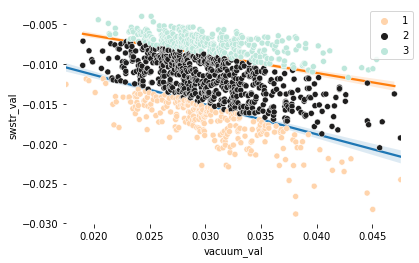

In [ ]:
sns.regplot(x='vacuum_val', y='swstr_val', data=pitch_ranks.loc[pitch_ranks['_split']==1], scatter=False)
sns.regplot(x='vacuum_val', y='swstr_val', data=pitch_ranks.loc[pitch_ranks['_split']==0], scatter=False)
sns.scatterplot(x='vacuum_val', y='swstr_val', data=pitch_ranks, hue='tier',zorder=5, palette='icefire_r')
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
_count_thresh = pitch_ranks.loc[:, ['player_name', 'tier']].groupby('player_name', as_index=False).count().rename(columns={'tier':'count'})
_count_thresh = _count_thresh.loc[_count_thresh['count']>=2]
most_t1_pitches = _count_thresh.merge(pitch_ranks.loc[:, ['player_name', 'tier']].groupby('player_name', as_index=False).mean())
most_t1_pitches.sort_values('tier').head(10)

player_name  count      tier
274     Roberto Osuna      2  1.000000
248     Nick Anderson      2  1.000000
105      Emilio Pagan      2  1.000000
30        Blake Snell      3  1.333333
222   Masahiro Tanaka      3  1.333333
191  Justin Verlander      3  1.333333
280      Ryan Pressly      3  1.333333
17      Andrew Heaney      3  1.333333
78      Daniel Norris      3  1.333333
229      Matthew Boyd      2  1.500000

In [ ]:
target_pitcher = 'Tommy Milone'
df_plt = pitch_ranks.loc[pitch_ranks['player_name']==target_pitcher, ['pitch_type','swstr_val', 'vacuum_val']]

# target_pitcher2 = 'Kyle Hendricks'
# df_plt2 = pitch_ranks.loc[pitch_ranks['player_name']==target_pitcher2, ['pitch_type','swstr_val', 'vacuum_val']]

sns.regplot(x='vacuum_val', y='swstr_val', data=pitch_ranks.loc[pitch_ranks['_split']==1], scatter=False)
sns.regplot(x='vacuum_val', y='swstr_val', data=pitch_ranks.loc[pitch_ranks['_split']==0], scatter=False)
sns.scatterplot(x='vacuum_val', y='swstr_val', data=pitch_ranks, hue='tier',zorder=5, palette='summer_r', alpha=.2, legend=False)
sns.scatterplot(x='vacuum_val', y='swstr_val', data=df_plt, hue='pitch_type',palette='hls', s=100,zorder=6)
# sns.scatterplot(x='vacuum_val', y='swstr_val', data=df_plt2, hue='pitch_type',palette='gnuplot', s=100,zorder=6, marker='v')
plt.title(target_pitcher)

sns.despine(left=True, bottom=True)
plt.show()

NameError: ignored

In [ ]:
pitch_ranks.shape

(1179, 13)

count    1179.000000
mean       -0.011849
std         0.004089
min        -0.028814
25%        -0.014741
50%        -0.011322
75%        -0.008511
max        -0.004013
Name: swstr_val, dtype: float64

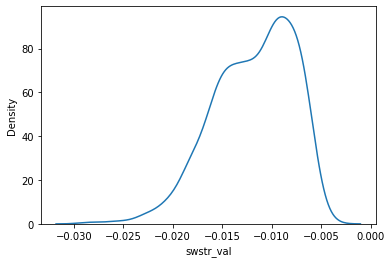

In [ ]:
sns.kdeplot(pitch_ranks['swstr_val'])
pitch_ranks['swstr_val'].describe()

In [ ]:
pitch_ranks.tail(20)

pitcher        player_name  ... lost_stuff  rank
1159  544931.0  Stephen Strasburg  ...   0.049808  1160
1160  544727.0     Jeurys Familia  ...   0.056520  1161
1161  594798.0       Jacob deGrom  ...   0.053584  1162
1162  519443.0    Brandon Workman  ...   0.055876  1163
1163  593833.0       Wander Suero  ...   0.054294  1164
1164  502043.0        Kyle Gibson  ...   0.048565  1165
1165  612434.0      Miguel Castro  ...   0.050225  1166
1166  573127.0        Zac Rosscup  ...   0.057040  1167
1167  444468.0      Hector Rondon  ...   0.051810  1168
1168  572096.0   Trevor Rosenthal  ...   0.054967  1169
1169  519393.0      Marcus Walden  ...   0.055526  1170
1170  453562.0       Jake Arrieta  ...   0.052171  1171
1171  605177.0      Andrew Chafin  ...   0.053881  1172
1172  543351.0        Jay Jackson  ...   0.058630  1173
1173  605513.0   Spencer Turnbull  ...   0.055088  1174
1174  641835.0          Tim Mayza  ...   0.056320  1175
1175  521230.0      Liam Hendriks  ...   0.049613  1176
1176  458681.0         Lance Lynn  ...   0.057744  1177
1177  543243.0         Sonny Gray  ...   0.052020  1178
1178  663432.0      Tanner Rainey  ...   0.052630  1179

[20 rows x 13 columns]

In [ ]:
pitch_ranks.loc[pitch_ranks['player_name']=='Clayton Kershaw']

pitcher      player_name  ... lost_stuff rank
152  477132.0  Clayton Kershaw  ...   0.045832  153
192  477132.0  Clayton Kershaw  ...   0.048623  193
592  477132.0  Clayton Kershaw  ...   0.046323  593

[3 rows x 13 columns]

## pitcher level (no pitch types)

No handles with labels found to put in legend.


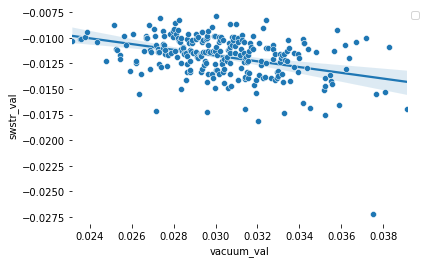

In [ ]:
# rank_by = 'vacuum_val'
threshold_n = 1000
threshold = (df_with_re
 .loc[:, ['pitcher','player_name', 're288_delta']]
 .groupby(['pitcher','player_name'],
          as_index=False)
 .count().rename(columns={'re288_delta':'times_thrown'}))

threshold = threshold.loc[threshold['times_thrown']>threshold_n]
pitch_ranks = (threshold
 .merge(df_with_re
        .loc[:, ['pitcher','player_name',
                 're288_delta', 'pitch_level_runs', 'vacuum_val', 'swstr_val',
                 'actual_stuff_value', 'ideal_stuff_value', 'lost_stuff']]
        .groupby(['pitcher','player_name'],
                 as_index=False)
        .mean())
 .sort_values(rank_by)).reset_index(drop=True)
# pitch_ranks['rank'] = range(1,pitch_ranks.shape[0]+1)

sns.regplot(x='vacuum_val', y='swstr_val', data=pitch_ranks, scatter=False)
sns.scatterplot(x='vacuum_val', y='swstr_val', data=pitch_ranks,zorder=5)
plt.legend(bbox_to_anchor=(1.05, 1))
sns.despine(left=True, bottom=True)
plt.show()

# calc break values

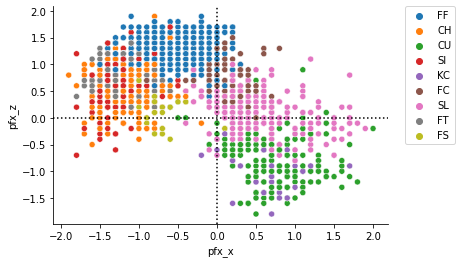

In [ ]:
pitch_break = df_with_re.loc[:, ['p_throws','pitch_type', 'pfx_x', 'pfx_z', 're288_delta']].dropna()
pitch_break.loc[pitch_break['p_throws']=='L', 'pfx_x'] = pitch_break.loc[pitch_break['p_throws']=='L', 'pfx_x'].mul(-1)
for col in ['pfx_x', 'pfx_z']:
  pitch_break[f'{col}_round'] = pitch_break[col].mul(10).round(0).div(10)

sns.scatterplot(x='pfx_x',y='pfx_z',data=pitch_break.sample(2000), hue='pitch_type')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

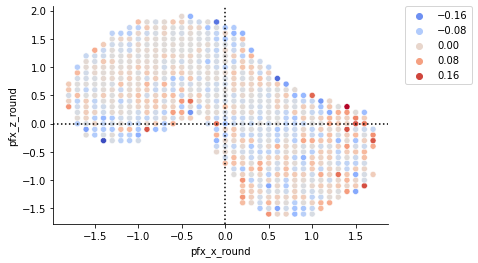

In [ ]:
qual_break = pitch_break.loc[:, ['pfx_x_round', 'pfx_z_round', 're288_delta']].groupby(['pfx_x_round', 'pfx_z_round'], as_index=False).count()
qual_break = qual_break.loc[qual_break['re288_delta']>qual_break['re288_delta'].median(), ['pfx_x_round', 'pfx_z_round']]

df_plt = pitch_break.loc[:, ['pfx_x_round', 'pfx_z_round', 're288_delta']].groupby(['pfx_x_round', 'pfx_z_round'], as_index=False).mean()
df_plt = df_plt.merge(qual_break)

sns.scatterplot(x='pfx_x_round',y='pfx_z_round',data=df_plt, hue='re288_delta', palette='coolwarm')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

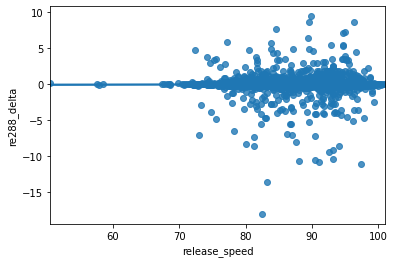

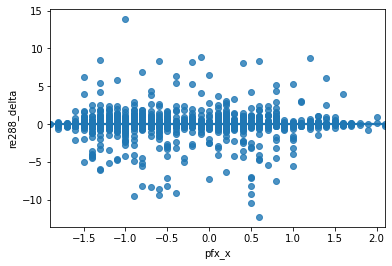

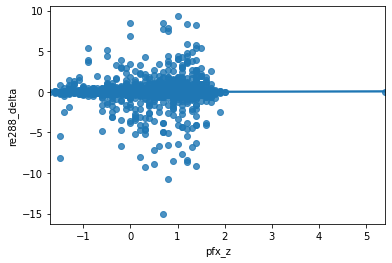

In [ ]:
df_plt = df_with_re.loc[:, ['p_throws', 'release_speed', 'pfx_x', 'pfx_z', 're288_delta']].dropna()
df_plt.loc[df_plt['p_throws']=='L', 'pfx_x'] = df_plt.loc[df_plt['p_throws']=='L', 'pfx_x'].mul(-1)
for col in ['release_speed', 'pfx_x', 'pfx_z']:
  sns.regplot(x=col, y='re288_delta', data=df_plt.sample(5000))
  plt.show()

There isn't much difference in break value other than very specific breaks on the edges. also, there isn't correlation with velo or break in general. But maybe it's possible to see based off of specific pitch types?

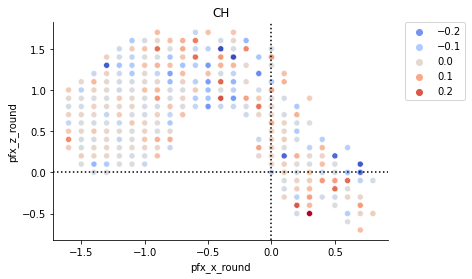

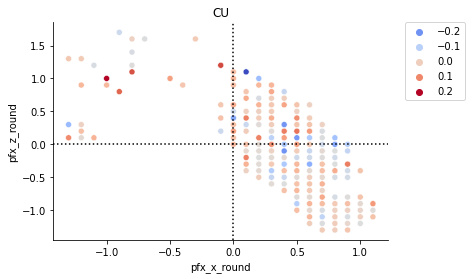

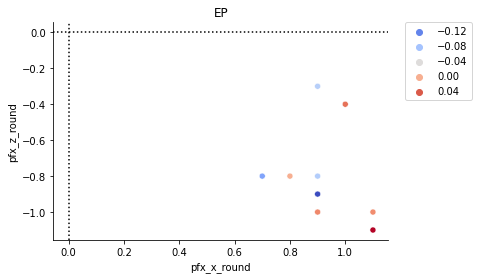

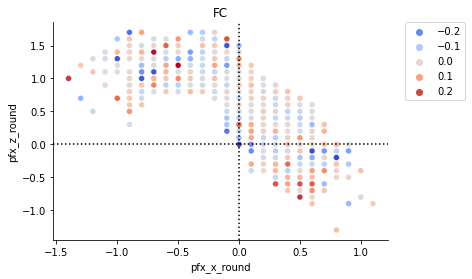

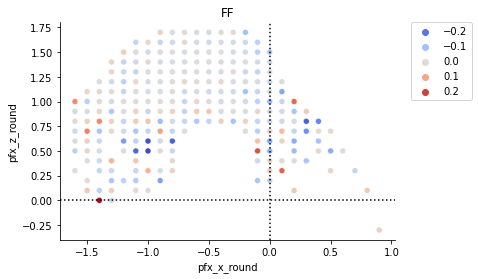

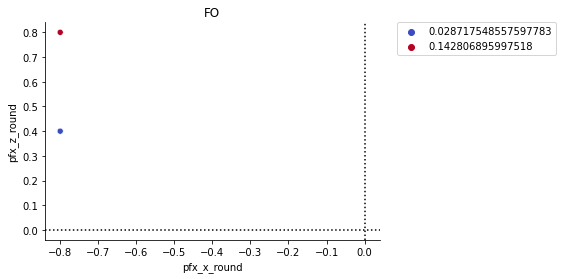

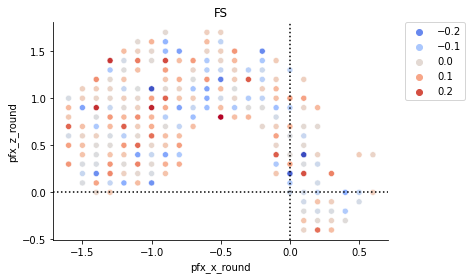

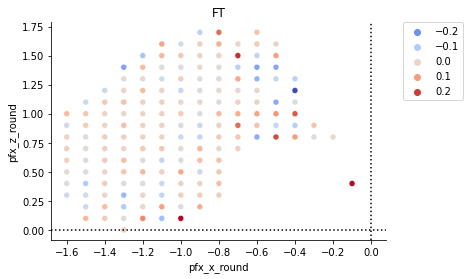

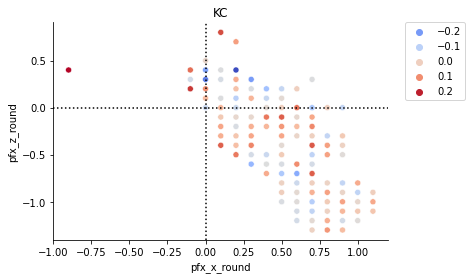

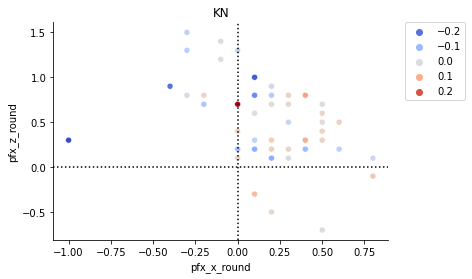

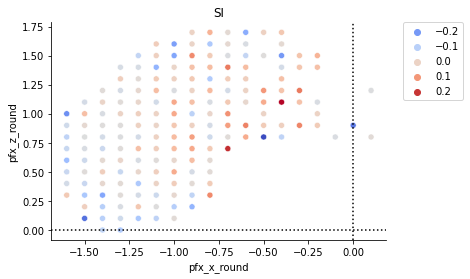

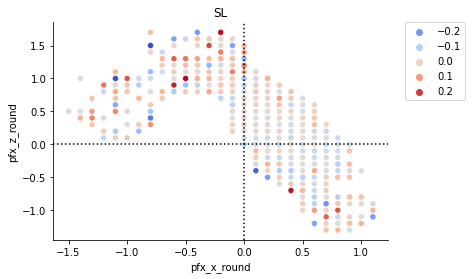

In [ ]:
_df_plt = pitch_break.loc[:, ['pitch_type', 'pfx_x_round', 'pfx_z_round', 're288_delta']].groupby(['pitch_type', 'pfx_x_round', 'pfx_z_round'], as_index=False).mean()
qual_break = pitch_break.loc[:, ['pfx_x_round', 'pfx_z_round', 're288_delta']].groupby(['pfx_x_round', 'pfx_z_round'], as_index=False).count()
qual_break = qual_break.loc[qual_break['re288_delta']>qual_break['re288_delta'].mean(), ['pfx_x_round', 'pfx_z_round']]
for pt in _df_plt['pitch_type'].unique():
  df_plt = _df_plt.loc[(_df_plt['pitch_type']==pt) & (_df_plt['re288_delta'].between(_df_plt['re288_delta'].quantile(.05), _df_plt['re288_delta'].quantile(.95)))].merge(qual_break)

  sns.scatterplot(x='pfx_x_round',y='pfx_z_round',data=df_plt, hue='re288_delta', palette='coolwarm')
  plt.title(pt)
  plt.axhline(0,c='k', ls=':')
  plt.axvline(0,c='k', ls=':')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  sns.despine()
  plt.show()

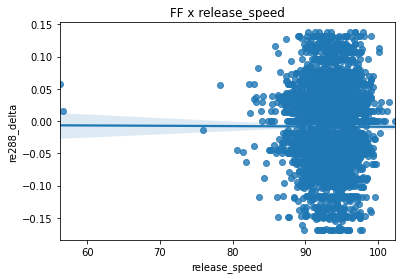

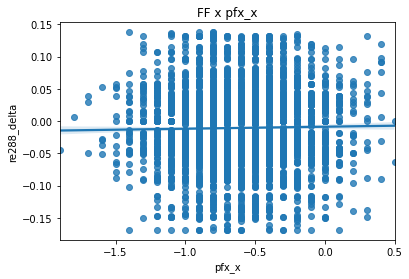

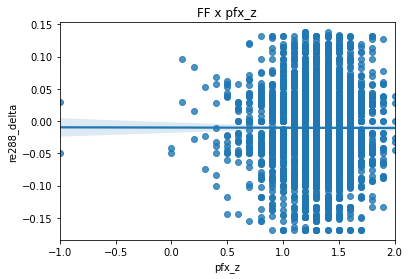

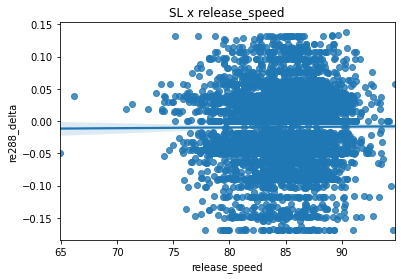

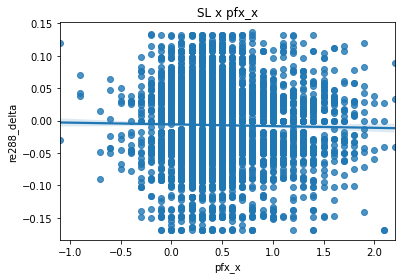

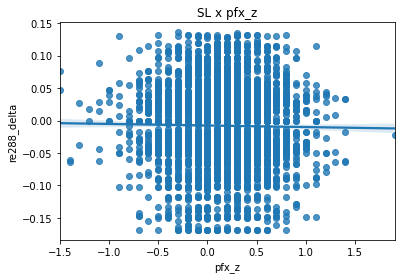

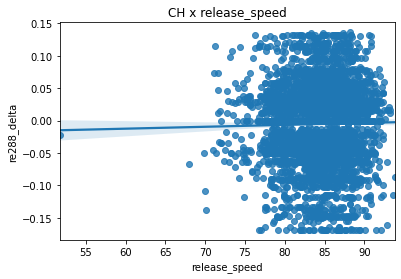

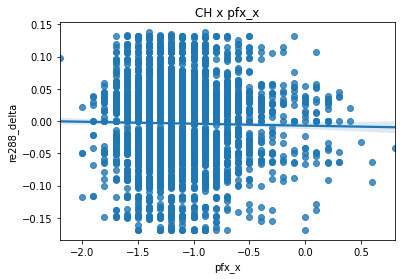

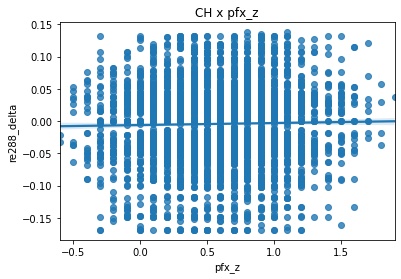

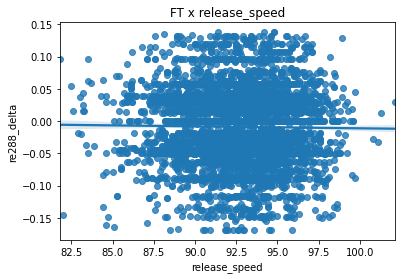

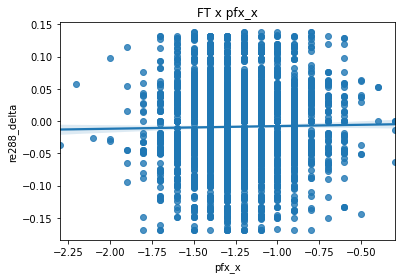

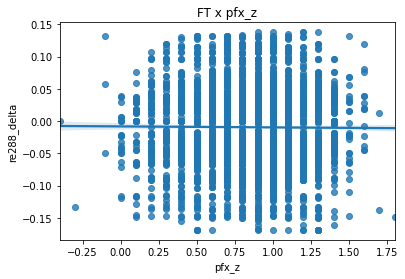

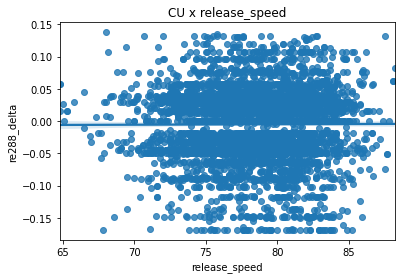

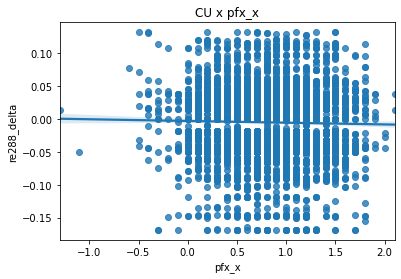

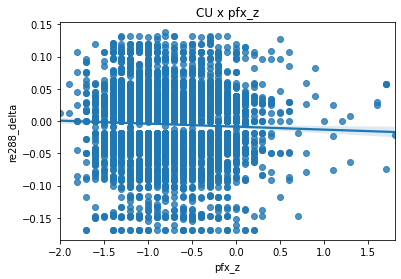

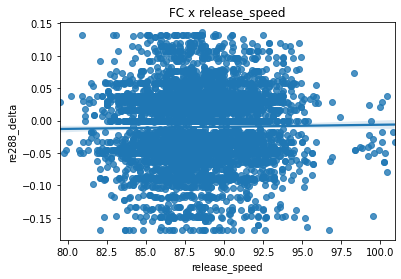

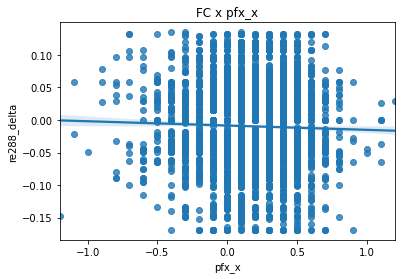

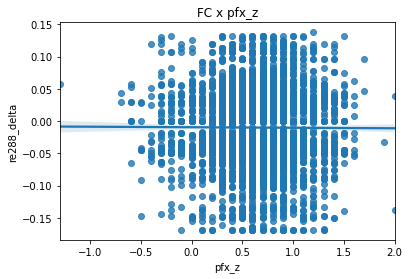

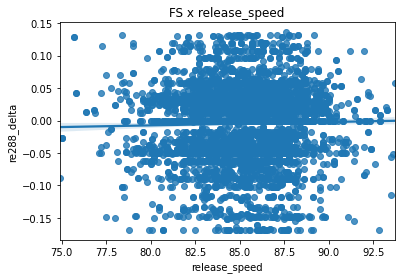

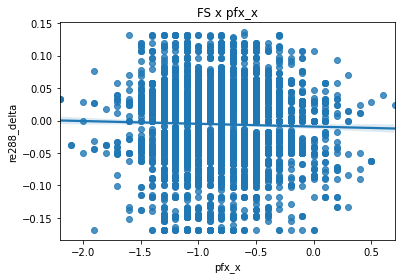

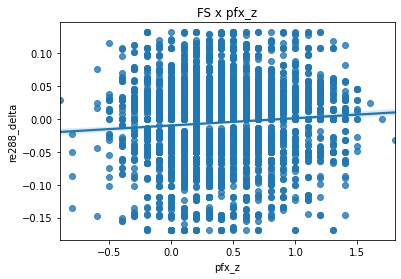

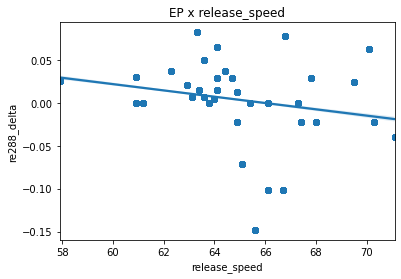

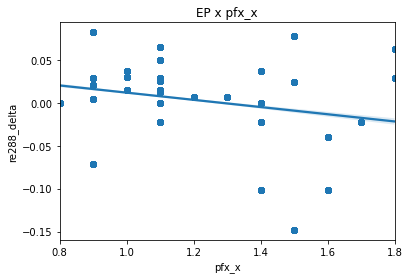

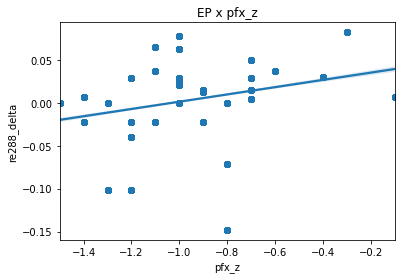

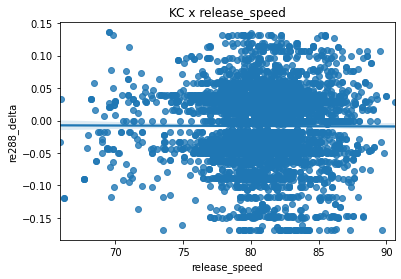

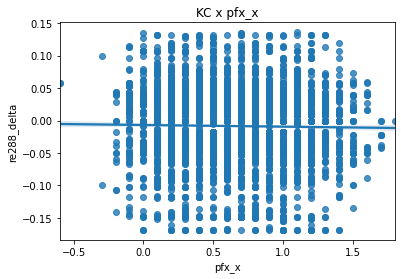

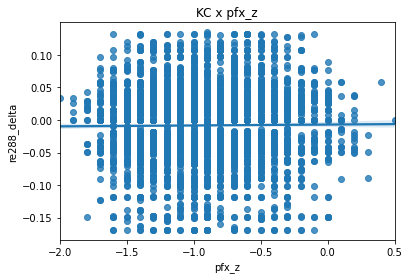

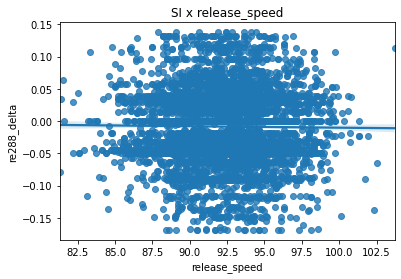

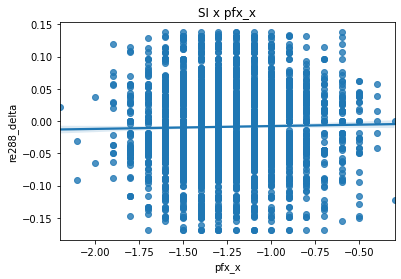

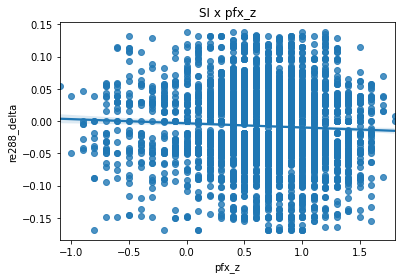

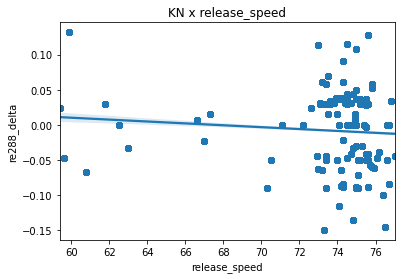

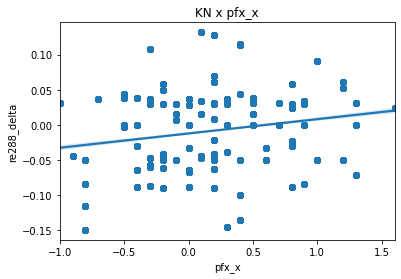

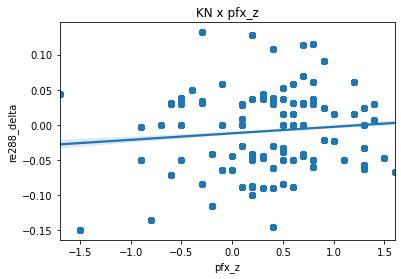

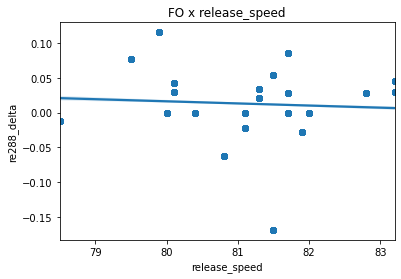

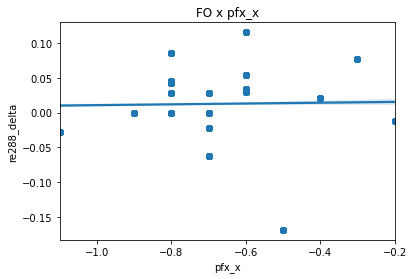

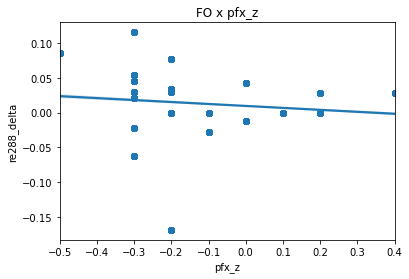

In [ ]:
df_plt = df_with_re.loc[df_with_re['type']!='X', ['p_throws', 'pitch_type', 'release_speed', 'pfx_x', 'pfx_z', 're288_delta']].dropna()
df_plt.loc[df_plt['p_throws']=='L', 'pfx_x'] = df_plt.loc[df_plt['p_throws']=='L', 'pfx_x'].mul(-1)
df_plt = df_plt.loc[df_plt['re288_delta'].between(df_plt['re288_delta'].quantile(.05), df_plt['re288_delta'].quantile(.95))]
for pt in df_plt['pitch_type'].unique():
  for col in ['release_speed', 'pfx_x', 'pfx_z']:
    sns.regplot(x=col, y='re288_delta', data=df_plt.loc[df_plt['pitch_type']==pt].sample(5000, replace=True))
    plt.title(f"{pt} x {col}")
    plt.show()

so this doesn't have a clear univariate correlation, even split by pitch type. so if we make a model that considers all of these factors (and remember, we are just trying to evaluate movement of the pitch, location value already has its own solution) then that should sort of result in something useful? but these factors really aren't correlating so... idk. might need something else (like relative values?)

let's make a few different models with a few different assumptions. and also let's start with a pitch type-less model first.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


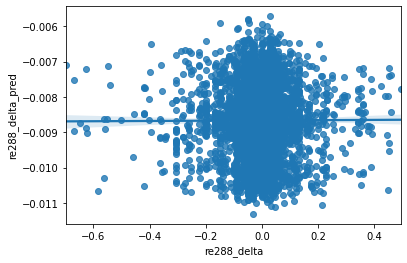

In [ ]:
model_feats = ['release_speed', 'pfx_x', 'pfx_z']
target = 're288_delta'
model_data = df_with_re.loc[df_with_re['type']!='X', model_feats+[target]].dropna()
model_data = model_data.loc[model_data[target].between(model_data[target].quantile(0.01), model_data[target].quantile(0.99))]
kf = KFold(10, shuffle=True)
df_pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = LinearRegression()
  model.fit(train.loc[:, model_feats], train.loc[:, target])
  df_pred = df_pred.append(pd.Series(model.predict(test.loc[:, model_feats]), index=test.index))
model_data[f'{target}_pred'] = df_pred
sns.regplot(target,f"{target}_pred",data=model_data.sample(5000))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


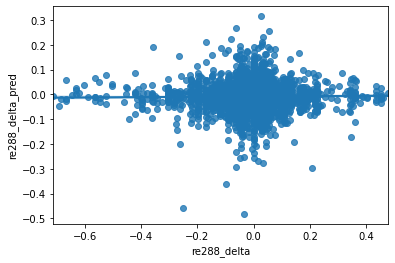

In [ ]:
model_feats = ['release_speed', 'pfx_x', 'pfx_z']
target = 're288_delta'
model_data = df_with_re.loc[df_with_re['type']!='X', model_feats+[target]].dropna()
model_data = model_data.loc[model_data[target].between(model_data[target].quantile(0.01), model_data[target].quantile(0.99))]
kf = KFold(3, shuffle=True)
df_pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train.loc[:, model_feats], train.loc[:, target])
  df_pred = df_pred.append(pd.Series(model.predict(test.loc[:, model_feats]), index=test.index))
model_data[f'{target}_pred'] = df_pred
sns.regplot(target,f"{target}_pred",data=model_data.sample(5000))
plt.show()

random forest does not look very accurate. might want to try setting break relative to a pitcher's fastball break?

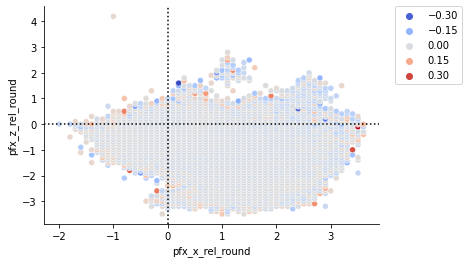

In [ ]:
pitch_break = df_with_re.loc[(df_with_re['type']!='X') & (df_with_re['re288_delta'].between(df_with_re['re288_delta'].quantile(.05), df_with_re['re288_delta'].quantile(.95))), ['p_throws','pitch_type', 'pfx_x_rel', 'pfx_z_rel', 're288_delta']].dropna()
pitch_break.loc[pitch_break['p_throws']=='L', 'pfx_x_rel'] = pitch_break.loc[pitch_break['p_throws']=='L', 'pfx_x_rel'].mul(-1)

for col in ['pfx_x_rel', 'pfx_z_rel']:
  pitch_break[f'{col}_round'] = pitch_break[col].mul(10).round(0).div(10)

df_plt = pitch_break.loc[:, ['pfx_x_rel_round', 'pfx_z_rel_round', 're288_delta']].groupby(['pfx_x_rel_round', 'pfx_z_rel_round'], as_index=False).mean()

sns.scatterplot(x='pfx_x_rel_round', y='pfx_z_rel_round', data=df_plt, hue='re288_delta', palette='coolwarm')
sns.despine()
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


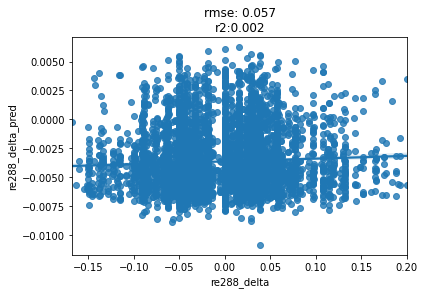

In [ ]:
model_feats = ['bat_side_right', 'release_speed', 'pfx_x_rel', 'pfx_z_rel']
target = 're288_delta'

model_data = df_with_re.loc[df_with_re['des'].isna(), model_feats+[target]].dropna()
model_data = model_data.loc[model_data[target].between(model_data[target].quantile(0.01), model_data[target].quantile(0.99))]

kf = KFold(10, shuffle=True)
df_pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = LinearRegression()
  model.fit(train.loc[:, model_feats], train.loc[:, target])
  df_pred = df_pred.append(pd.Series(model.predict(test.loc[:, model_feats]), index=test.index))
model_data[f'{target}_pred'] = df_pred

rmse = mean_squared_error(model_data[target], model_data[f"{target}_pred"])**0.5
r2 = pearsonr(model_data[target], model_data[f"{target}_pred"])[0]**2

sns.regplot(target,f"{target}_pred",data=model_data.sample(5000))
plt.title(f"rmse: {round(rmse, 3)}\nr2:{round(r2, 3)}")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


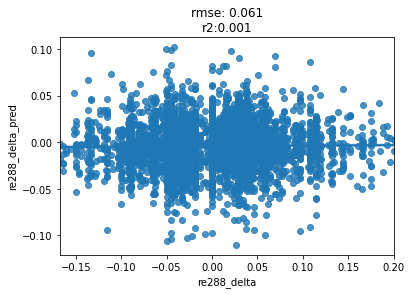

In [ ]:
model_feats = ['bat_side_right', 'release_speed', 'pfx_x_rel', 'pfx_z_rel']
target = 're288_delta'
model_data = df_with_re.loc[df_with_re['des'].isna(), model_feats+[target]].dropna()
model_data = model_data.loc[model_data[target].between(model_data[target].quantile(0.01), model_data[target].quantile(0.99))]

kf = KFold(3, shuffle=True)
df_pred = pd.Series()

for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train.loc[:, model_feats], train.loc[:, target])
  df_pred = df_pred.append(pd.Series(model.predict(test.loc[:, model_feats]), index=test.index))
model_data[f'{target}_pred'] = df_pred

rmse = mean_squared_error(model_data[target], model_data[f"{target}_pred"])**0.5
r2 = pearsonr(model_data[target], model_data[f"{target}_pred"])[0]**2

sns.regplot(target,f"{target}_pred",data=model_data.sample(5000))
plt.title(f"rmse: {round(rmse, 3)}\nr2:{round(r2, 3)}")
plt.show()

In [ ]:
df_with_re[f'{target}_break_rf_pred'] = pd.Series(model.predict(df_with_re.loc[:, model_feats].dropna()), index=df_with_re.loc[:, model_feats].dropna().index)

In [ ]:
df_with_re.columns.values

array(['index', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter',
       'pitcher', 'events', 'description', 'spin_dir',
       'spin_rate_deprecated', 'break_angle_deprecated',
       'break_length_deprecated', 'zone', 'des', 'game_type', 'stand',
       'p_throws', 'home_team', 'away_team', 'type', 'hit_location',
       'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z',
       'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
       'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated',
       'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4',
       'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release

In [ ]:
df_with_re.loc[:, ['re288_delta', 're288_delta_loc_rf_pred', 're288_delta_break_rf_pred']]
df_with_re['stuff_score'] = df_with_re['re288_delta_loc_rf_pred'].add(df_with_re['re288_delta_break_rf_pred'])

In [ ]:
df_agg = df_with_re.loc[:, ['player_name','pitch_type','re288_delta','stuff_score']].groupby(['player_name','pitch_type'], as_index=False).sum()
df_agg.sort_values('re288_delta')

player_name pitch_type  re288_delta  stuff_score
1727         Josh Osich         FC  -158.478008   -16.189001
839       Derek Holland         SI  -137.754761   -16.361686
2175      Miguel Castro         SI  -112.225292   -10.842369
3127       Wei-Yin Chen         FF  -112.069402   -15.190969
2312       Nick Vincent         FF  -103.556870   -10.879648
...                 ...        ...          ...          ...
958   Eduardo Rodriguez         CH    95.423307     7.423492
1115        Gerrit Cole         SL    95.587218    -8.040257
1261      Jack Flaherty         SL   100.450462   -12.406656
1190       Homer Bailey         FF   100.877409   -30.535319
1112        Gerrit Cole         FF   146.783505   -43.790435

[3269 rows x 4 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


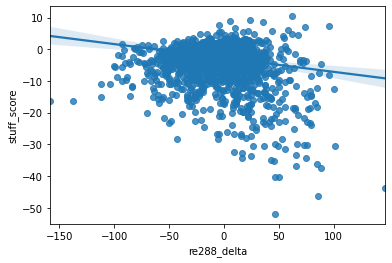

In [ ]:
sns.regplot('re288_delta', 'stuff_score',data=df_agg)

In [ ]:
model_feats = ['balls', 'strikes']
target = 'runs_scored'
model_data = df.loc[(df['balls']<4) & (df['strikes']<3), model_feats+[target]].dropna()
model = LinearRegression()
model.fit(model_data.loc[:, model_feats], model_data[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
_count_value['model_val'] = model.predict(_count_value.loc[:, ['balls','strikes']])
_count_value
pd.pivot_table(_count_value.loc[_count_value['balls']<4, ['balls', 'strikes', 'model_val']], columns='strikes', index='balls').style.background_gradient(cmap='coolwarm')

In [ ]:
model.predict([[0,0]])

array([0.])

In [ ]:
_count_value = df.loc[:, ['balls', 'strikes', 'runs_scored']].groupby(['balls', 'strikes'], as_index=False).mean()
count_adj = _count_value.loc[(_count_value['balls']==0) & (_count_value['strikes']==0), 'runs_scored'].values[0]
_count_value['runs_scored'] = _count_value['runs_scored'].sub(count_adj)
_count_value.sort_values(['strikes', 'balls'])

balls  strikes  runs_scored
0     0.0      0.0     0.000000
3     1.0      0.0     0.002506
6     2.0      0.0     0.015293
9     3.0      0.0    -0.137712
1     0.0      1.0    -0.039019
4     1.0      1.0    -0.034459
7     2.0      1.0    -0.002913
10    3.0      1.0    -0.078700
12    4.0      1.0    -0.200320
2     0.0      2.0    -0.130351
5     1.0      2.0    -0.127865
8     2.0      2.0    -0.111182
11    3.0      2.0    -0.118374

In [ ]:
_extrema = df.loc[(df['plate_x']==df['plate_x'].max()) |
              (df['plate_x']==df['plate_x'].min()) |
              (df['plate_z']==df['plate_z'].min()) |
              (df['plate_z']==df['plate_z'].max())]
model_data = (df
              .sample(50000)
              .dropna(subset=['plate_x', 'plate_z', 'qualified_strikes'])
              .append(_extrema)
              .drop_duplicates())
gam = LogisticGAM(f(0) + f(1)).fit(model_data.loc[:, ['plate_x', 'plate_z']],
                                 model_data['qualified_strikes'])
_df = df.loc[:, ['plate_x', 'plate_z']].dropna()
df['qualified_strikes_pred'] = pd.Series(gam.predict_proba(_df), index=_df.index)

_extrema_break = df.loc[(df['pfx_x']==df['pfx_x'].max()) |
              (df['pfx_x']==df['pfx_x'].min()) |
              (df['pfx_z']==df['pfx_z'].min()) |
              (df['pfx_z']==df['pfx_z'].max()),
              ['pfx_x', 'pfx_z','qualified_strikes']]
model_data_break = (df
                    .loc[:,['pfx_x', 'pfx_z','qualified_strikes']]
                    .dropna()
                    .sample(50000)
                    .append(_extrema_break)
                    .drop_duplicates())
gam_break = LogisticGAM(f(0) + f(1)).fit(model_data_break.loc[:, ['pfx_x', 'pfx_z']],
                                 model_data_break['qualified_strikes'])
_df = df.loc[:, ['pfx_x', 'pfx_z']].dropna()
df['qualified_strikes_break_pred'] = pd.Series(gam.predict_proba(_df), index=_df.index)

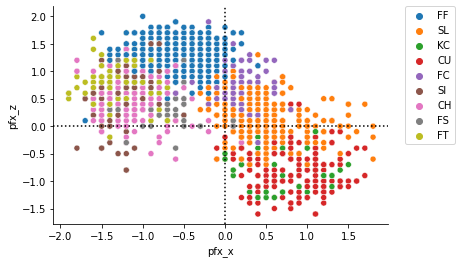

In [ ]:
sns.scatterplot(x='pfx_x',y='pfx_z',data=pitch_break.sample(2000), hue='pitch_type')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

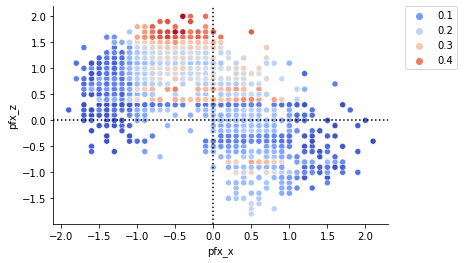

In [ ]:
sns.scatterplot(x='pfx_x',y='pfx_z',data=pitch_break.sample(2000), hue='qualified_strikes_break_pred', palette='coolwarm')
plt.axhline(0,c='k', ls=':')
plt.axvline(0,c='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

In [ ]:
pitch_loc = df.loc[:, ['p_throws','pitch_type', 'plate_x', 'plate_z', 'qualified_strikes', 'qualified_strikes_pred']].dropna()

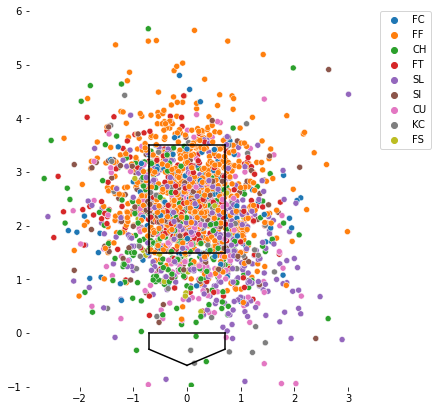

In [ ]:
fig = sns.scatterplot(x='plate_x',y='plate_z',data=pitch_loc.sample(2000), hue='pitch_type')
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
rf = RandomForestClassifier()
rf.fit(model_data.loc[:, ['plate_x', 'plate_z']], model_data['qualified_strikes'])
_df = df.loc[:, ['plate_x', 'plate_z']].dropna()

In [ ]:
df_pred = pd.DataFrame()
for x,y in itertools.product(np.arange(-2,2,0.1), np.arange(0,5,0.1)):
  _df_pred = pd.DataFrame()
  _df_pred['plate_x'] = [x]
  _df_pred['plate_z'] = y
  _df_pred['qualified_strikes_pred'] = gam.predict_proba([[x, y]])
  _df_pred['qualified_strikes_rf'] = rf.predict_proba([[x, y]])[0][1]
  df_pred = df_pred.append(_df_pred, ignore_index=True)

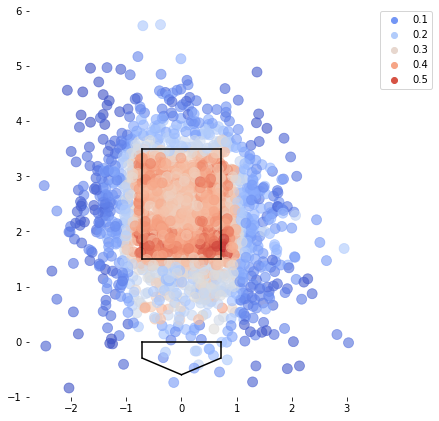

In [ ]:
fig = sns.scatterplot(x='plate_x',y='plate_z',data=df.sample(2000),
                      hue='qualified_strikes_pred', palette='coolwarm',
                      s=100, edgecolor=None, alpha=.6)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

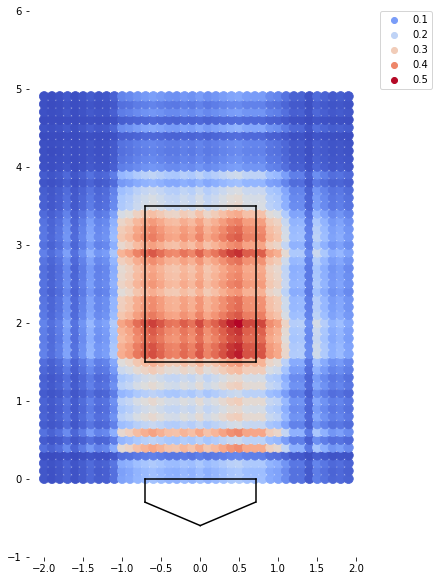

In [ ]:
fig = sns.scatterplot(x='plate_x',y='plate_z',data=df_pred,
                      hue='qualified_strikes_pred', palette='coolwarm',
                      s=90, edgecolor=None)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

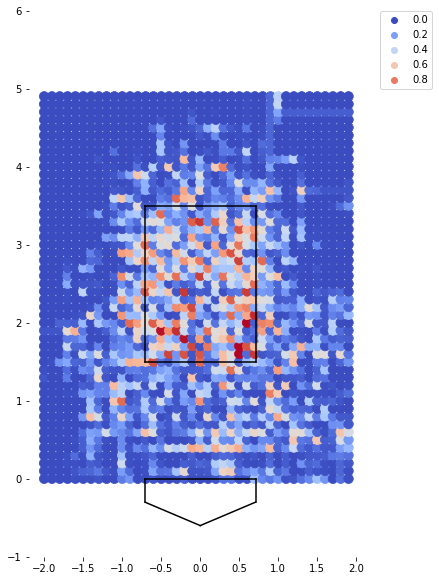

In [ ]:
fig = sns.scatterplot(x='plate_x',y='plate_z',data=df_pred, hue='qualified_strikes_rf', palette='coolwarm', s=90, edgecolor=None)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
runs_per_event = df.loc[:, ['events','runs_scored']].groupby('events', as_index=False).mean().sort_values('runs_scored', ascending=False)

In [ ]:
events = ['batter_interference', 'caught_stealing_2b',
       'caught_stealing_3b', 'caught_stealing_home', 'double',
       'double_play', 'field_error', 'field_out', 'fielders_choice',
       'fielders_choice_out', 'force_out', 'grounded_into_double_play',
       'hit_by_pitch', 'home_run', 'interf_def', 'other_out',
       'pickoff_1b', 'pickoff_2b', 'pickoff_3b',
       'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_3b',
       'pickoff_caught_stealing_home', 'run', 'sac_bunt',
       'sac_bunt_double_play', 'sac_fly', 'sac_fly_double_play', 'single',
       'strikeout', 'strikeout_double_play', 'triple', 'triple_play',
       'walk']

In [ ]:
# event_gams = {}
# for e in tqdm(runs_per_event['events'].unique(), leave=True):
#   _gam = LogisticGAM(f(0) + f(1)).fit(model_data.loc[:, ['plate_x', 'plate_z']],
#                                       model_data.loc[:, e])
#   event_gams[e] = _gam

# with open('/content/drive/My Drive/stuff_score/event_gams.pickle', 'wb') as handle:
#     pickle.dump(event_gams, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1111: RuntimeWarning: divide by zero encountered in double_scalars
  r2['explained_deviance'] = 1. - full_d.sum()/null_d.sum()
/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1112: RuntimeWarning: divide by zero encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1113: RuntimeWarning: divide by zero encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1111: RuntimeWarning: divide by zero encountered in double_scalars
  r2['explained_deviance'] = 1. - full_d.sum()/null_d.sum()
/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1112: RuntimeWarning: divide by zero encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
/usr/local/lib/python3.6/dist-packages/pygam/pygam.py:1113: RuntimeWarning: divide by zero encountered in double_scalars
  r2['McFad

In [ ]:
with open('/content/drive/My Drive/stuff_score/event_gams.pickle', 'rb') as handle:
    event_gams = pickle.load(handle)


In [ ]:
_df = df.loc[:, ['plate_x', 'plate_z']].dropna()
for e in tqdm(runs_per_event.loc[runs_per_event['runs_scored']>0, 'events'].tolist(), leave=True):
  v = runs_per_event.loc[runs_per_event['events']==e, 'runs_scored'].values[0]
  _gam = event_gams[e]
  df[f"{e}_value_pred"] = pd.Series(_gam.predict_proba(_df),
                                    index=_df.index).mul(v)

value_cols = [x for x in df.columns.values if 'value_pred' in x]
df['loc_ev'] = df.loc[:, value_cols].sum(axis=1)

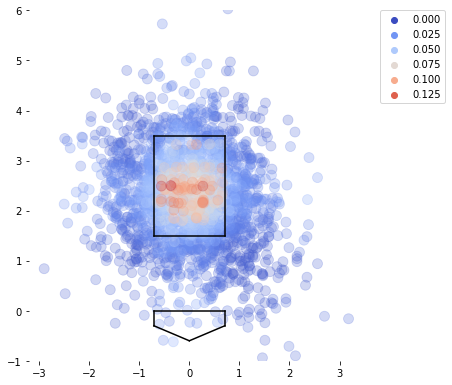

In [ ]:
df_plt = df.sample(2000).sort_values('loc_ev')
fig = sns.scatterplot(x='plate_x',y='plate_z',data=df_plt,
                      hue='loc_ev', palette='coolwarm',
                      s=100, edgecolor=None, alpha=.25)
fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
_df = df.loc[:, ['plate_x', 'plate_z']].dropna()
for e in tqdm(runs_per_event.loc[runs_per_event['runs_scored']>0, 'events'].tolist(), leave=True):
  v = runs_per_event.loc[runs_per_event['events']==e, 'runs_scored'].values[0]
  _gam = event_gams[e]
  df[f"{e}_value_pred"] = pd.Series(_gam.predict_proba(_df),
                                    index=_df.index).mul(v)

value_cols = [x for x in df.columns.values if 'value_pred' in x]
df['loc_ev'] = df.loc[:, value_cols].sum(axis=1)

(743572, 149)

In [ ]:
df_pred = pd.DataFrame()
for x,y in itertools.product(np.arange(-2,2,0.1), np.arange(0,5,0.1)):
  for e in runs_per_event.loc[runs_per_event['runs_scored']>0, 'events'].tolist():
    v = runs_per_event.loc[runs_per_event['events']==e, 'runs_scored'].values[0]
    _gam = event_gams[e]
    _df_pred = pd.DataFrame()
    _df_pred['plate_x'] = [x]
    _df_pred['plate_z'] = y
    _df_pred[f'{e}_value_pred'] = _gam.predict_proba([[x, y]])
    df_pred = df_pred.append(_df_pred, ignore_index=True)

In [ ]:
value_cols = [x for x in df_pred.columns.values if 'value_pred' in x]
df_pred['loc_ev'] = df_pred.loc[:, value_cols].sum(axis=1)

In [ ]:
df.loc[df['type']=='X', 'des']

10        George Springer pops out to second baseman Asd...
12        Juan Soto flies out to center fielder Jake Mar...
14        Anthony Rendon pops out to shortstop Carlos Co...
20        Adam Eaton singles on a ground ball to center ...
30        Victor Robles singles on a fly ball to center ...
                                ...                        
743553    Stephen Piscotty homers (1) on a fly ball to c...
743556    Matt Chapman flies out to center fielder Mitch...
743565    Jay Bruce singles on a sharp line drive to sho...
743566    Mitch Haniger pops out to first baseman Matt O...
743570    Dee Gordon lines out sharply to right fielder ...
Name: des, Length: 127534, dtype: object

In [ ]:
count_ev = df.loc[:, ['balls', 'strikes', 'runs_scored']].groupby(['balls', 'strikes'], as_index=False).mean()
pitch_value = df.loc[(df['strikes']<2) & (df['balls']<3), ['balls', 'strikes', 'type']].merge(count_ev)

pitch_value['post_balls'] = pitch_value['balls']
pitch_value.loc[pitch_value['type']=='B', 'post_balls'] = pitch_value.loc[pitch_value['type']=='B', 'balls'].add(1)

pitch_value['post_strikes'] = pitch_value['strikes']
pitch_value.loc[pitch_value['type']=='S', 'post_strikes'] = pitch_value.loc[pitch_value['type']=='S', 'strikes'].add(1)

pitch_value = pitch_value.merge(count_ev.add_prefix('post_'))
pitch_value['count_value'] = pitch_value['post_runs_scored'].sub(pitch_value['runs_scored'])
pitch_value.loc[:, ['type', 'count_value']].groupby('type', as_index=False).mean()

type  count_value
0    B    -0.002903
1    S    -0.059734
2    X     0.000000

In [ ]:
df_hm = pd.pivot_table(df_pred.loc[:, ['plate_x', 'plate_z', 'loc_ev']], columns='plate_x', index='plate_z')

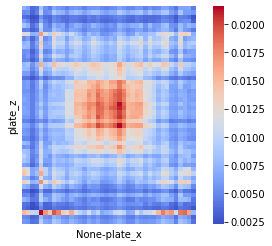

In [ ]:
fig = sns.heatmap(df_hm, cmap='coolwarm', cbar=True)
plt.xticks([])
plt.yticks([])
fig.set_aspect('equal')

plt.show()

In [ ]:
df_pred['loc_ev'].describe()

count    4.200000e+04
mean     8.631264e-03
std      2.255892e-02
min      7.682501e-12
25%      2.104312e-04
50%      8.000542e-04
75%      4.483637e-03
max      3.486722e-01
Name: loc_ev, dtype: float64

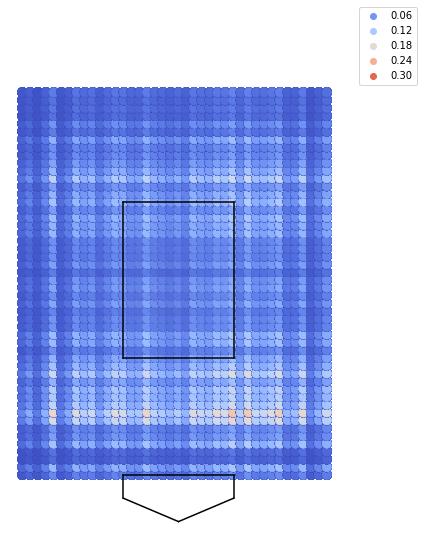

In [ ]:
fig = sns.scatterplot(x='plate_x',y='plate_z',data=df_pred,
                      hue='loc_ev', palette='coolwarm',
                      s=90, edgecolor=None)

# fig = plt.scatter(df_pred['plate_x'], df_pred['plate_z'], c=df_pred['loc_ev'], cmap='coolwarm')
# plt.colorbar(fig)
# fig = sns.heatmap(df_hm, cmap='coolwarm', cbar=False)
plt.xticks([])
plt.yticks([])

fig.set_ylim(-1, 6)
fig.set_aspect('equal')

draw_sz()
draw_home_plate(catcher_perspective=True)

plt.xlabel('')
plt.ylabel('')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0], 12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
df['runs_added'].describe()

count    743572.000000
mean          0.000094
std           0.009702
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: runs_added, dtype: float64